---

# Uncovering Lifestyle Driven Obesity Patterns through Clustering

**DRAFT NOTEBOOK**
---
---

In [1]:
#Importing all the required Libraries
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn import cluster
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score,silhouette_samples,davies_bouldin_score

# **Task 1 – The Data**

In [2]:
# Loading the dataset
raw_data = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
print(raw_data.shape)
raw_data.head()

(2111, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## **Dataset Explanation**

This dataset contains information about individuals and their lifestyle habits related to nutrition and physical activity. The goal is typically to identify patterns that relate to obesity levels, making it suitable for clustering people into lifestyle or health-related groups.

| **Feature**                      | **Range**                                                                                                                                     | **Explanation**                                                   |
|----------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------|
| `Gender`                         | {Male, Female}                                                                                                                                | Biological sex of the individual.                                 |
| `Age`                            | ℝ (e.g., 14–61)                                                                                                                               | Age of the individual in years.                                   |
| `Height`                         | ℝ (e.g., 1.45–1.98)                                                                                                                           | Height in meters.                                                 |
| `Weight`                         | ℝ (e.g., 39–173)                                                                                                                              | Weight in kilograms.                                              |
| `family_history_with_overweight`| {yes, no}                                                                                                                                      | Whether any family member has a history of being overweight.      |
| `FAVC`                           | {yes, no}                                                                                                                                      | Frequent consumption of high-caloric food.                        |
| `FCVC`                           | ℝ (1.0–3.0)                                                                                                                                    | Frequency of eating vegetables (1 = never, 3 = always).           |
| `NCP`                            | ℝ (1.0–4.0)                                                                                                                                    | Number of main meals per day.                                     |
| `CAEC`                           | {no, Sometimes, Frequently, Always}                                                                                                           | Consumption of food between meals.                                |
| `SMOKE`                          | {yes, no}                                                                                                                                      | Smoking habit.                                                    |
| `CH2O`                           | ℝ (1.0–3.0)                                                                                                                                    | Daily water consumption (1 = less, 3 = more).                     |
| `SCC`                            | {yes, no}                                                                                                                                      | Whether the person monitors their calorie intake.                 |
| `FAF`                            | ℝ (0.0–3.0)                                                                                                                                    | Frequency of physical activity (in hours per week).               |
| `TUE`                            | ℝ (0.0–2.0)                                                                                                                                    | Time spent using technology devices (in hours per day).           |
| `CALC`                           | {no, Sometimes, Frequently, Always}                                                                                                           | Frequency of alcohol consumption.                                 |
| `MTRANS`                         | {Automobile, Bike, Motorcycle, Public_Transportation, Walking}                                                                               | Mode of transportation used.                                      |
| `NObeyesdad`                     | {Insufficient_Weight, Normal_Weight, Overweight_Level_I, Overweight_Level_II, Obesity_Type_I, Obesity_Type_II, Obesity_Type_III}            | Target variable: classification of obesity level.                 |


## **Suitability for Clustering**
This dataset is well-suited for clustering due to the following reasons:
* The dataset includes essential lifestyle and health metrics like BMI, physical activity level, and eating habits, which are key indicators for obesity and suitable for clustering analysis.

* Continuous and ordinal variables allow effective clustering to identify patterns in lifestyle-driven obesity risk profiles.

* The dataset’s structure and diversity of features make it ideal for segmenting the population into meaningful clusters, uncovering hidden behavioral patterns that can support personalized public health strategies.



# **Task 2 – Initial Data Analysis**

In [3]:
# Displaying the number of rows and columns in the dataset

print(f"Dataset contains {raw_data.shape[0]} rows and {raw_data.shape[1]} columns.")

Dataset contains 2111 rows and 17 columns.


In [4]:
# Basic information about the dataset

print("\nDataset Info:\n")
raw_data.info()


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF               

In [5]:
# Statistical summary of the dataset
print("\nStatistical Summary:")
display(raw_data.describe(include='all'))


Statistical Summary:


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
count,2111,2111.000000,2111.000000,2111.000000,2111,2111,2111.000000,2111.000000,2111,2111,2111.000000,2111,2111.000000,2111.000000,2111,2111,2111
unique,2,NaN,NaN,NaN,2,2,NaN,NaN,4,2,NaN,2,NaN,NaN,4,5,7
top,Male,NaN,NaN,NaN,yes,yes,NaN,NaN,Sometimes,no,NaN,no,NaN,NaN,Sometimes,Public_Transportation,Obesity_Type_I
freq,1068,NaN,NaN,NaN,1726,1866,NaN,NaN,1765,2067,NaN,2015,NaN,NaN,1401,1580,351
mean,NaN,24.312600,1.701677,86.586058,NaN,NaN,2.419043,2.685628,NaN,NaN,2.008011,NaN,1.010298,0.657866,NaN,NaN,NaN
std,NaN,6.345968,0.093305,26.191172,NaN,NaN,0.533927,0.778039,NaN,NaN,0.612953,NaN,0.850592,0.608927,NaN,NaN,NaN
min,NaN,14.000000,1.450000,39.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,19.947192,1.630000,65.473343,NaN,NaN,2.000000,2.658738,NaN,NaN,1.584812,NaN,0.124505,0.000000,NaN,NaN,NaN
50%,NaN,22.777890,1.700499,83.000000,NaN,NaN,2.385502,3.000000,NaN,NaN,2.000000,NaN,1.000000,0.625350,NaN,NaN,NaN
75%,NaN,26.000000,1.768464,107.430682,NaN,NaN,3.000000,3.000000,NaN,NaN,2.477420,NaN,1.666678,1.000000,NaN,NaN,NaN


In [6]:
# Displaying the descriptive statistics for all numeric columns

raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2111.0,24.312600,6.345968,14.00,19.947192,22.777890,26.000000,61.00
Height,2111.0,1.701677,0.093305,1.45,1.630000,1.700499,1.768464,1.98
Weight,2111.0,86.586058,26.191172,39.00,65.473343,83.000000,107.430682,173.00
FCVC,2111.0,2.419043,0.533927,1.00,2.000000,2.385502,3.000000,3.00
NCP,2111.0,2.685628,0.778039,1.00,2.658738,3.000000,3.000000,4.00
CH2O,2111.0,2.008011,0.612953,1.00,1.584812,2.000000,2.477420,3.00
FAF,2111.0,1.010298,0.850592,0.00,0.124505,1.000000,1.666678,3.00
TUE,2111.0,0.657866,0.608927,0.00,0.000000,0.625350,1.000000,2.00


In [7]:
# Displaying the total number of null values in the dataset

print("\nList of Null Values:")
raw_data.isnull().sum()


List of Null Values:


,0
Gender,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0


In [8]:
# Displaying the total number of unique values for each column

raw_data.select_dtypes(include='object').nunique()

,0
Gender,2
family_history_with_overweight,2
FAVC,2
CAEC,4
SMOKE,2
SCC,2
CALC,4
MTRANS,5
NObeyesdad,7


# **Task 3 – Preprocessing**


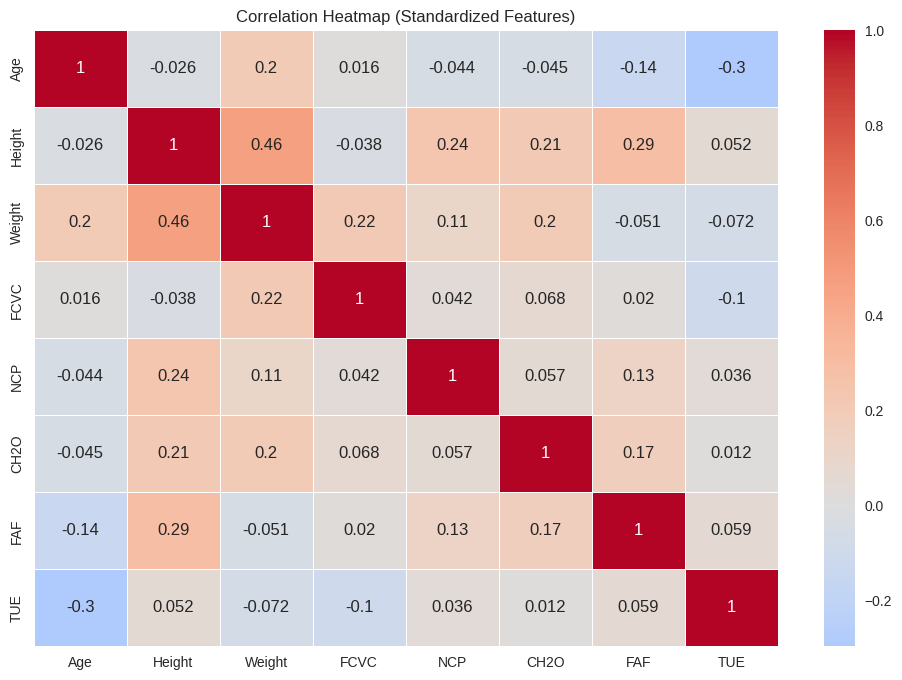

In [9]:
# Selecting only numeric columns
numeric_data = raw_data.select_dtypes(include=['number'])

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), cmap='coolwarm', center=0, linewidths=0.5, annot=True)
plt.title('Correlation Heatmap (Standardized Features)')
plt.show()

To examine the linear relationship among numeric variables, we performed a correlation heatmap of standardised data features. The values in the cells of the matrix range from -1 (where there is a strong negative correlation) to +1 (where there is a strong positive correlation).

## Insights:
- Firstly, weight and height are related positively moderately with the value of the coefficient (0.46) being as anticipated.
- Second, Weight and Age are moderately correlated with a positive correlation (0.20), suggesting that age could be having an impact on the trend of weight.
- Other characteristics, such as TUE (Technology Use for Exercise), are negatively or weakly related to the other characteristics, indicating they may vary independently. The matrix is useful for revealing relationships that affect decision making and clustering by highlighting likely feature interactions.

Numeric columns: Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')


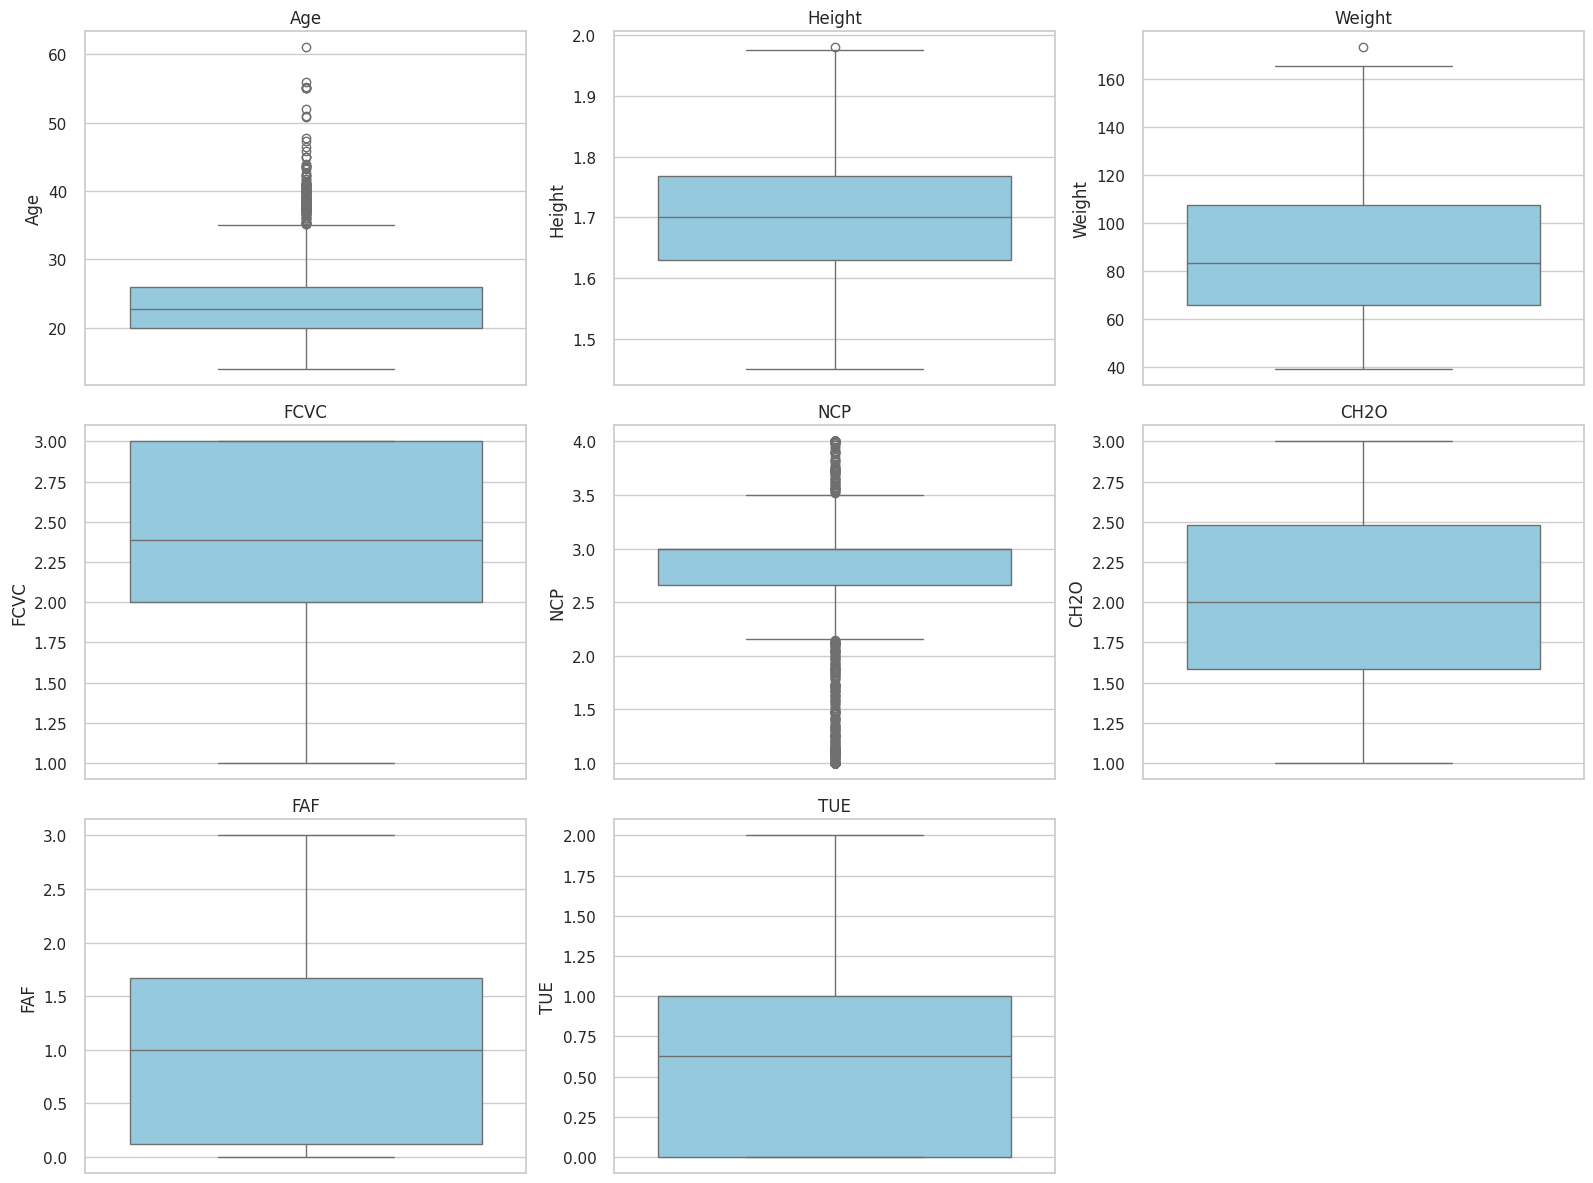

In [10]:
# Selecting the numeric columns and ploting the box plots to visualize the distribution and detect outliers across features

numeric_cols = raw_data.select_dtypes(include=['float64', 'int64']).columns
print("Numeric columns:", numeric_cols)
sns.set(style="whitegrid")

ncols = 3
nrows = math.ceil(len(numeric_cols) / ncols)

plt.figure(figsize=(16, 4 * nrows))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(nrows, ncols, i)
    sns.boxplot(y=raw_data[col], color='skyblue')
    plt.title(f'{col}')

plt.tight_layout()
plt.show()

## Insights:
- **Age:** Most values occur at an age less than 30, but there are some values over 40.
- **Height:** Heights occur around 1.7 m together with an outlier above 1.9.
- **Weight:** Weights are very spread out around a median of 85kg, including several outliers above 160kg.
- **FCVC (Frequency of Vegetable Consumption):** Values are generally high, and also together at almost every value between 2 and 3.
- **NCP (Number of Main Meals):** Generally, all values are clustering around 3 meals, as well as clustering at either end.
- **CH2O (Water Recommendation):** Most people drink between 1.5 to 2.5 litres of water per day with no significant outliers.
- **FAF (Fruit and Activity Frequency):** Most physical activity is clustered toward lower values, but there is a wide interquartile range.
- **TUE (Technology use and exercise):** Technology use for exercise is generally very low and clustered into values of 0 and 1, with a few reaching a max of 2.

In [11]:
# Removing the outliers using IQR Method
filtered_data = raw_data.copy()
for col in numeric_cols:
    Q1 = filtered_data[col].quantile(0.25)
    Q3 = filtered_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = filtered_data[(filtered_data[col] >= lower_bound) & (filtered_data[col] <= upper_bound)]

In [12]:
filtered_data.shape

(1398, 17)

In [13]:
# Dropping NObeyesdad column from the dataset
df = filtered_data.drop(columns=["NObeyesdad"])

In [14]:
# Converting binary categorical columns to numerical format

binary_cols = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
for col in binary_cols:
    df[col] = df[col].map({"yes": 1, "no": 0})
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.000000,1.620000,64.000000,1,0,2.0,3.0,Sometimes,0,2.000000,0,0.000000,1.000000,no,Public_Transportation
1,Female,21.000000,1.520000,56.000000,1,0,3.0,3.0,Sometimes,1,3.000000,1,3.000000,0.000000,Sometimes,Public_Transportation
2,Male,23.000000,1.800000,77.000000,1,0,2.0,3.0,Sometimes,0,2.000000,0,2.000000,1.000000,Frequently,Public_Transportation
3,Male,27.000000,1.800000,87.000000,0,0,3.0,3.0,Sometimes,0,2.000000,0,2.000000,0.000000,Frequently,Walking
5,Male,29.000000,1.620000,53.000000,0,1,2.0,3.0,Sometimes,0,2.000000,0,0.000000,0.000000,Sometimes,Automobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,1,1,3.0,3.0,Sometimes,0,1.728139,0,1.676269,0.906247,Sometimes,Public_Transportation
2107,Female,21.982942,1.748584,133.742943,1,1,3.0,3.0,Sometimes,0,2.005130,0,1.341390,0.599270,Sometimes,Public_Transportation
2108,Female,22.524036,1.752206,133.689352,1,1,3.0,3.0,Sometimes,0,2.054193,0,1.414209,0.646288,Sometimes,Public_Transportation
2109,Female,24.361936,1.739450,133.346641,1,1,3.0,3.0,Sometimes,0,2.852339,0,1.139107,0.586035,Sometimes,Public_Transportation


In [15]:
# Applying one-hot encoding to selected categorical columns of the dataset.

one_hot_cols = ["Gender", "CAEC", "CALC", "MTRANS"]
data = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)
data

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,Gender_Male,CAEC_Frequently,CAEC_Sometimes,CAEC_no,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.000000,1.620000,64.000000,1,0,2.0,3.0,0,2.000000,0,0.000000,1.000000,False,False,True,False,False,True,False,False,True,False
1,21.000000,1.520000,56.000000,1,0,3.0,3.0,1,3.000000,1,3.000000,0.000000,False,False,True,False,True,False,False,False,True,False
2,23.000000,1.800000,77.000000,1,0,2.0,3.0,0,2.000000,0,2.000000,1.000000,True,False,True,False,False,False,False,False,True,False
3,27.000000,1.800000,87.000000,0,0,3.0,3.0,0,2.000000,0,2.000000,0.000000,True,False,True,False,False,False,False,False,False,True
5,29.000000,1.620000,53.000000,0,1,2.0,3.0,0,2.000000,0,0.000000,0.000000,True,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,1.710730,131.408528,1,1,3.0,3.0,0,1.728139,0,1.676269,0.906247,False,False,True,False,True,False,False,False,True,False
2107,21.982942,1.748584,133.742943,1,1,3.0,3.0,0,2.005130,0,1.341390,0.599270,False,False,True,False,True,False,False,False,True,False
2108,22.524036,1.752206,133.689352,1,1,3.0,3.0,0,2.054193,0,1.414209,0.646288,False,False,True,False,True,False,False,False,True,False
2109,24.361936,1.739450,133.346641,1,1,3.0,3.0,0,2.852339,0,1.139107,0.586035,False,False,True,False,True,False,False,False,True,False


# **Task 4 – Exploratory Data Analysis: Statistical Properties**

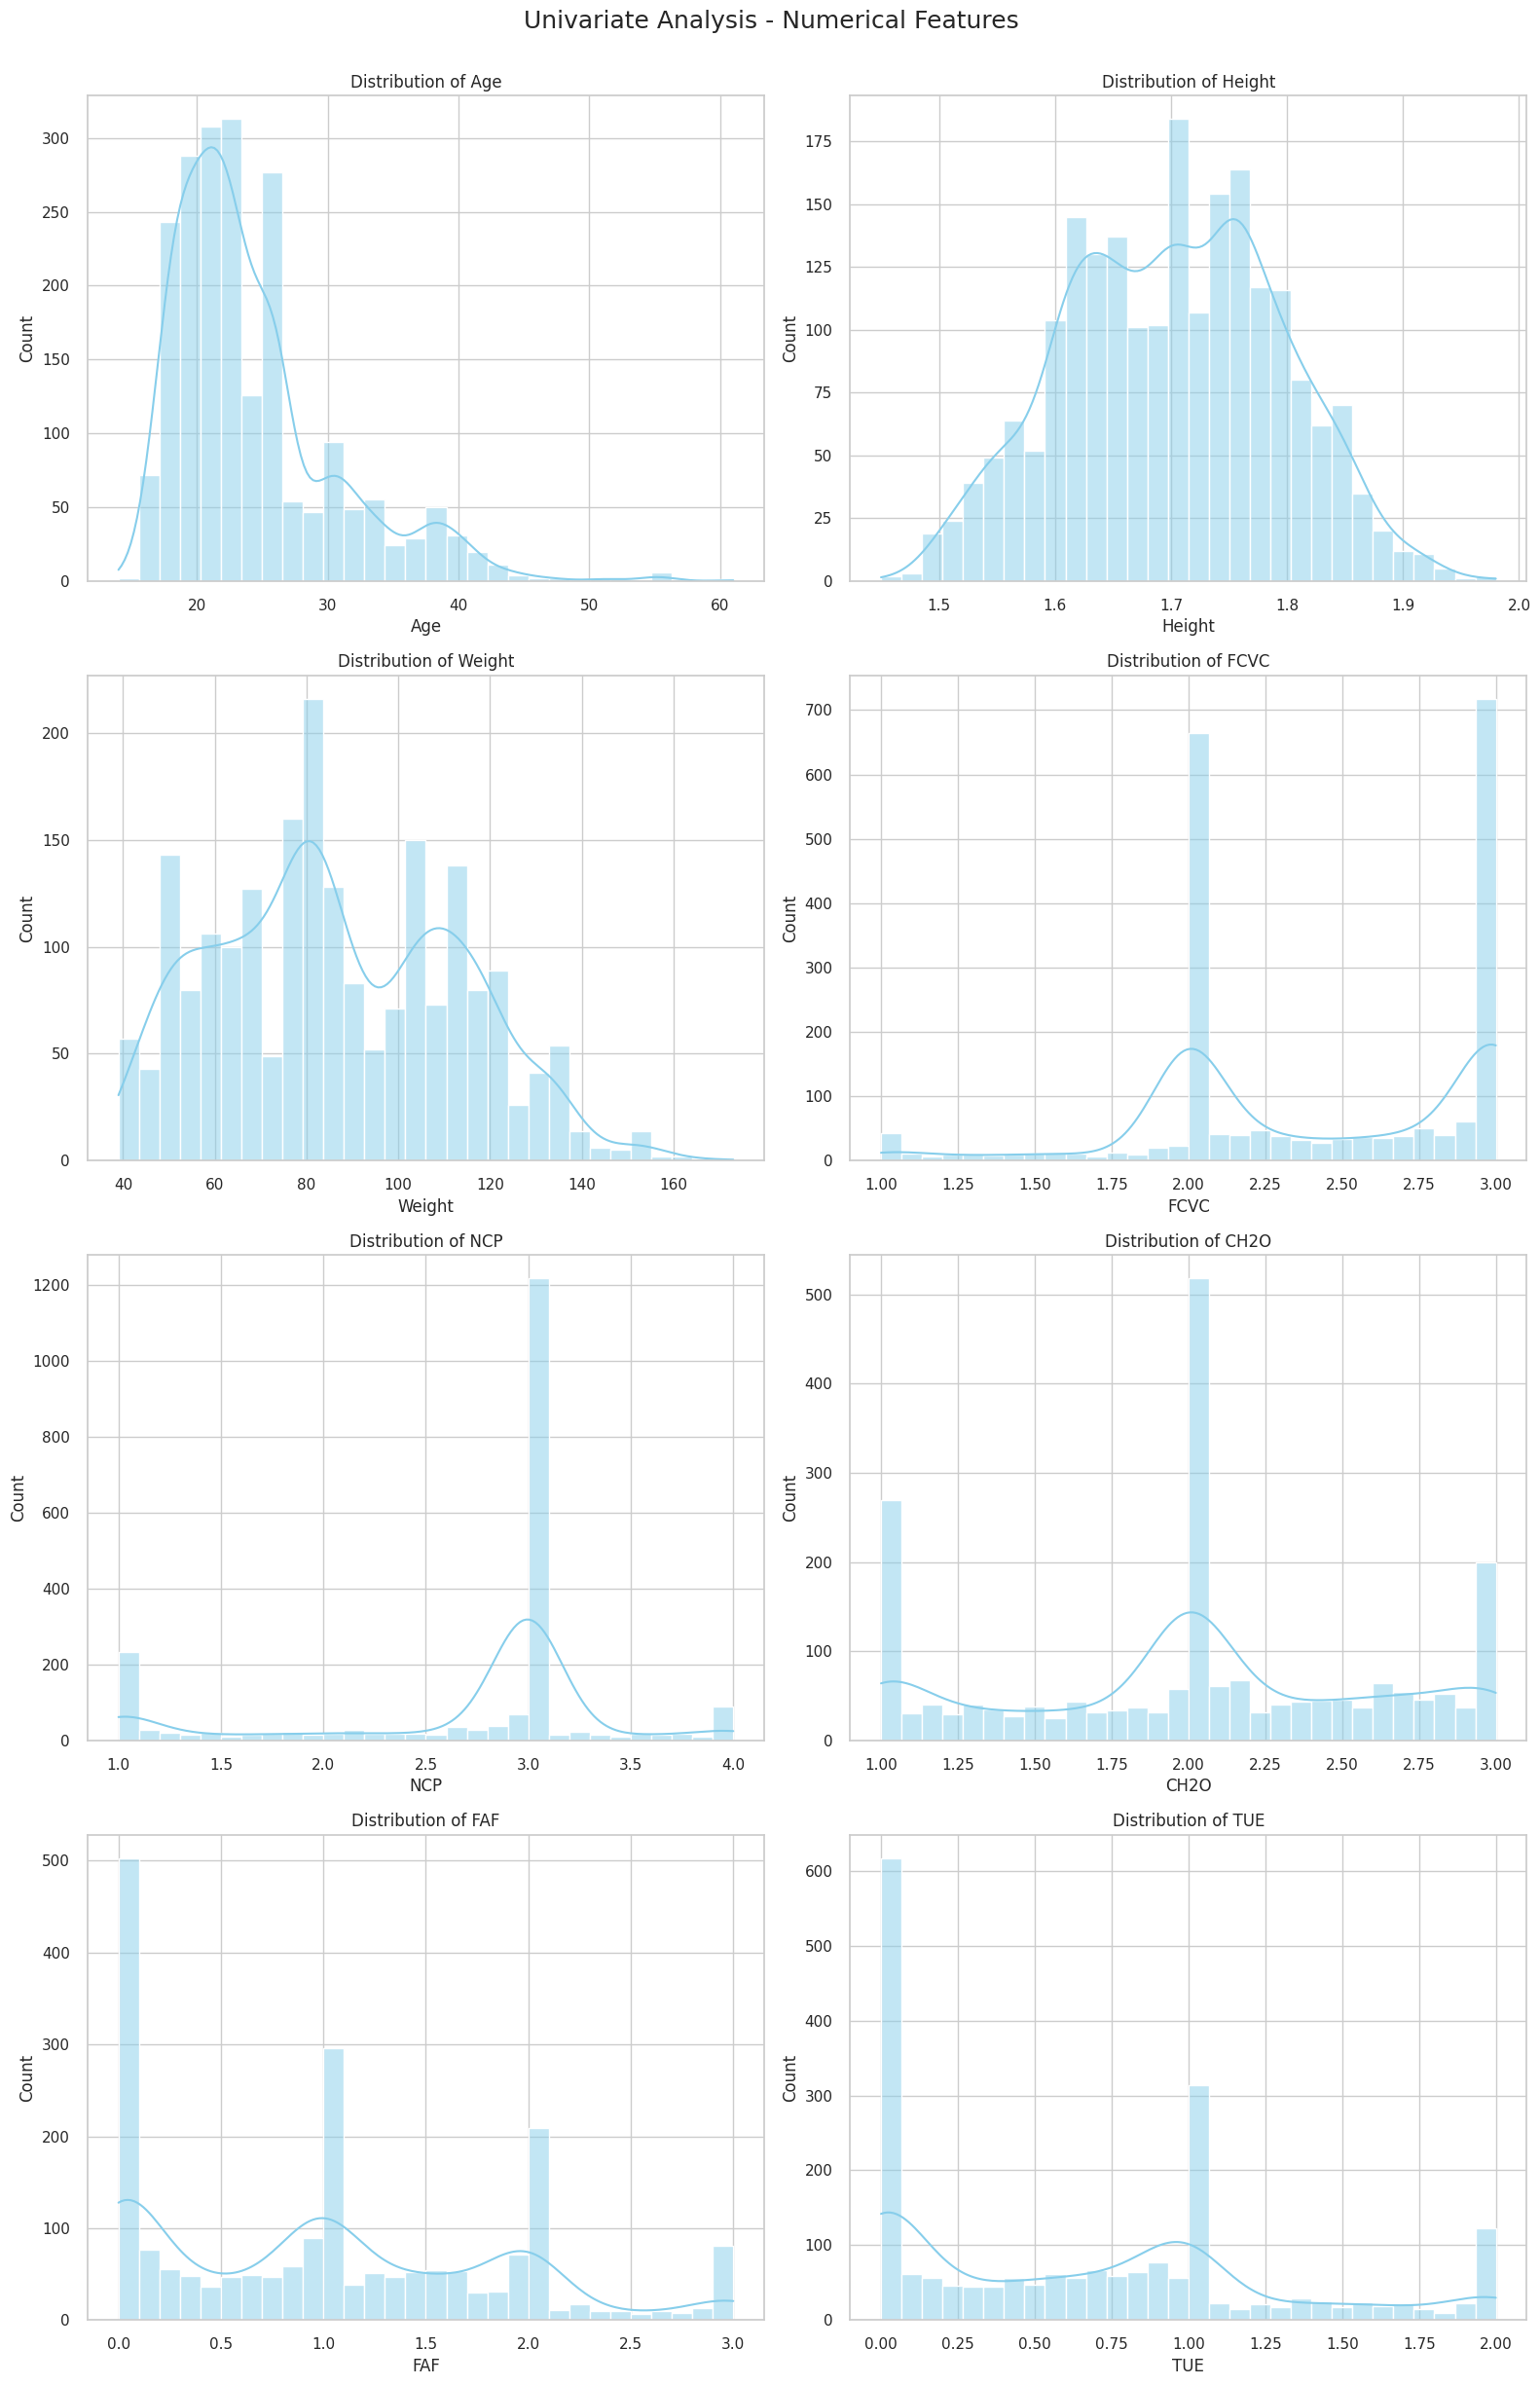

In [16]:
# Ploting distribution graph for all numerical columns

numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

plt.figure(figsize=(16, 24))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 2, i + 1)
    sns.histplot(raw_data[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.suptitle("Univariate Analysis - Numerical Features", fontsize=18, y=1.02)
plt.show()

## Key Insights

- **Age:** A right-skewed frequency distribution is seen in the age variable. Most of the age values lie between 15 and 30 years.

- **Height:** The data for height yields close to a normal distribution with an average height of approximately 1.7 metres.

- **Weight:** Weight frequency distribution is multi-modal, indicating that the participants possessed varying body sizes.

- **FCVC (Frequency of Vegetable Consumption):** The frequency values for FCVC clustered around 2 and 3, suggesting that participants consume vegetables at a reasonable frequency.

- **NCP (Number of Main Meals):** Counts for the number of meals consumed per day peaked at 3 meals, and it was determined that this is the most frequent amount consumed per day by participants.

- **CH2O (Water Intake):** The majority of participants reported consuming around 2 litres of water daily, with some reporting slightly less.

- **FAF (Frequency of Physical Activity):** A fair percentage of participants indicated very low to moderate physical activity.

- **TUE (Technology Use):** Most participants reported no to very little use of technology for exercise.

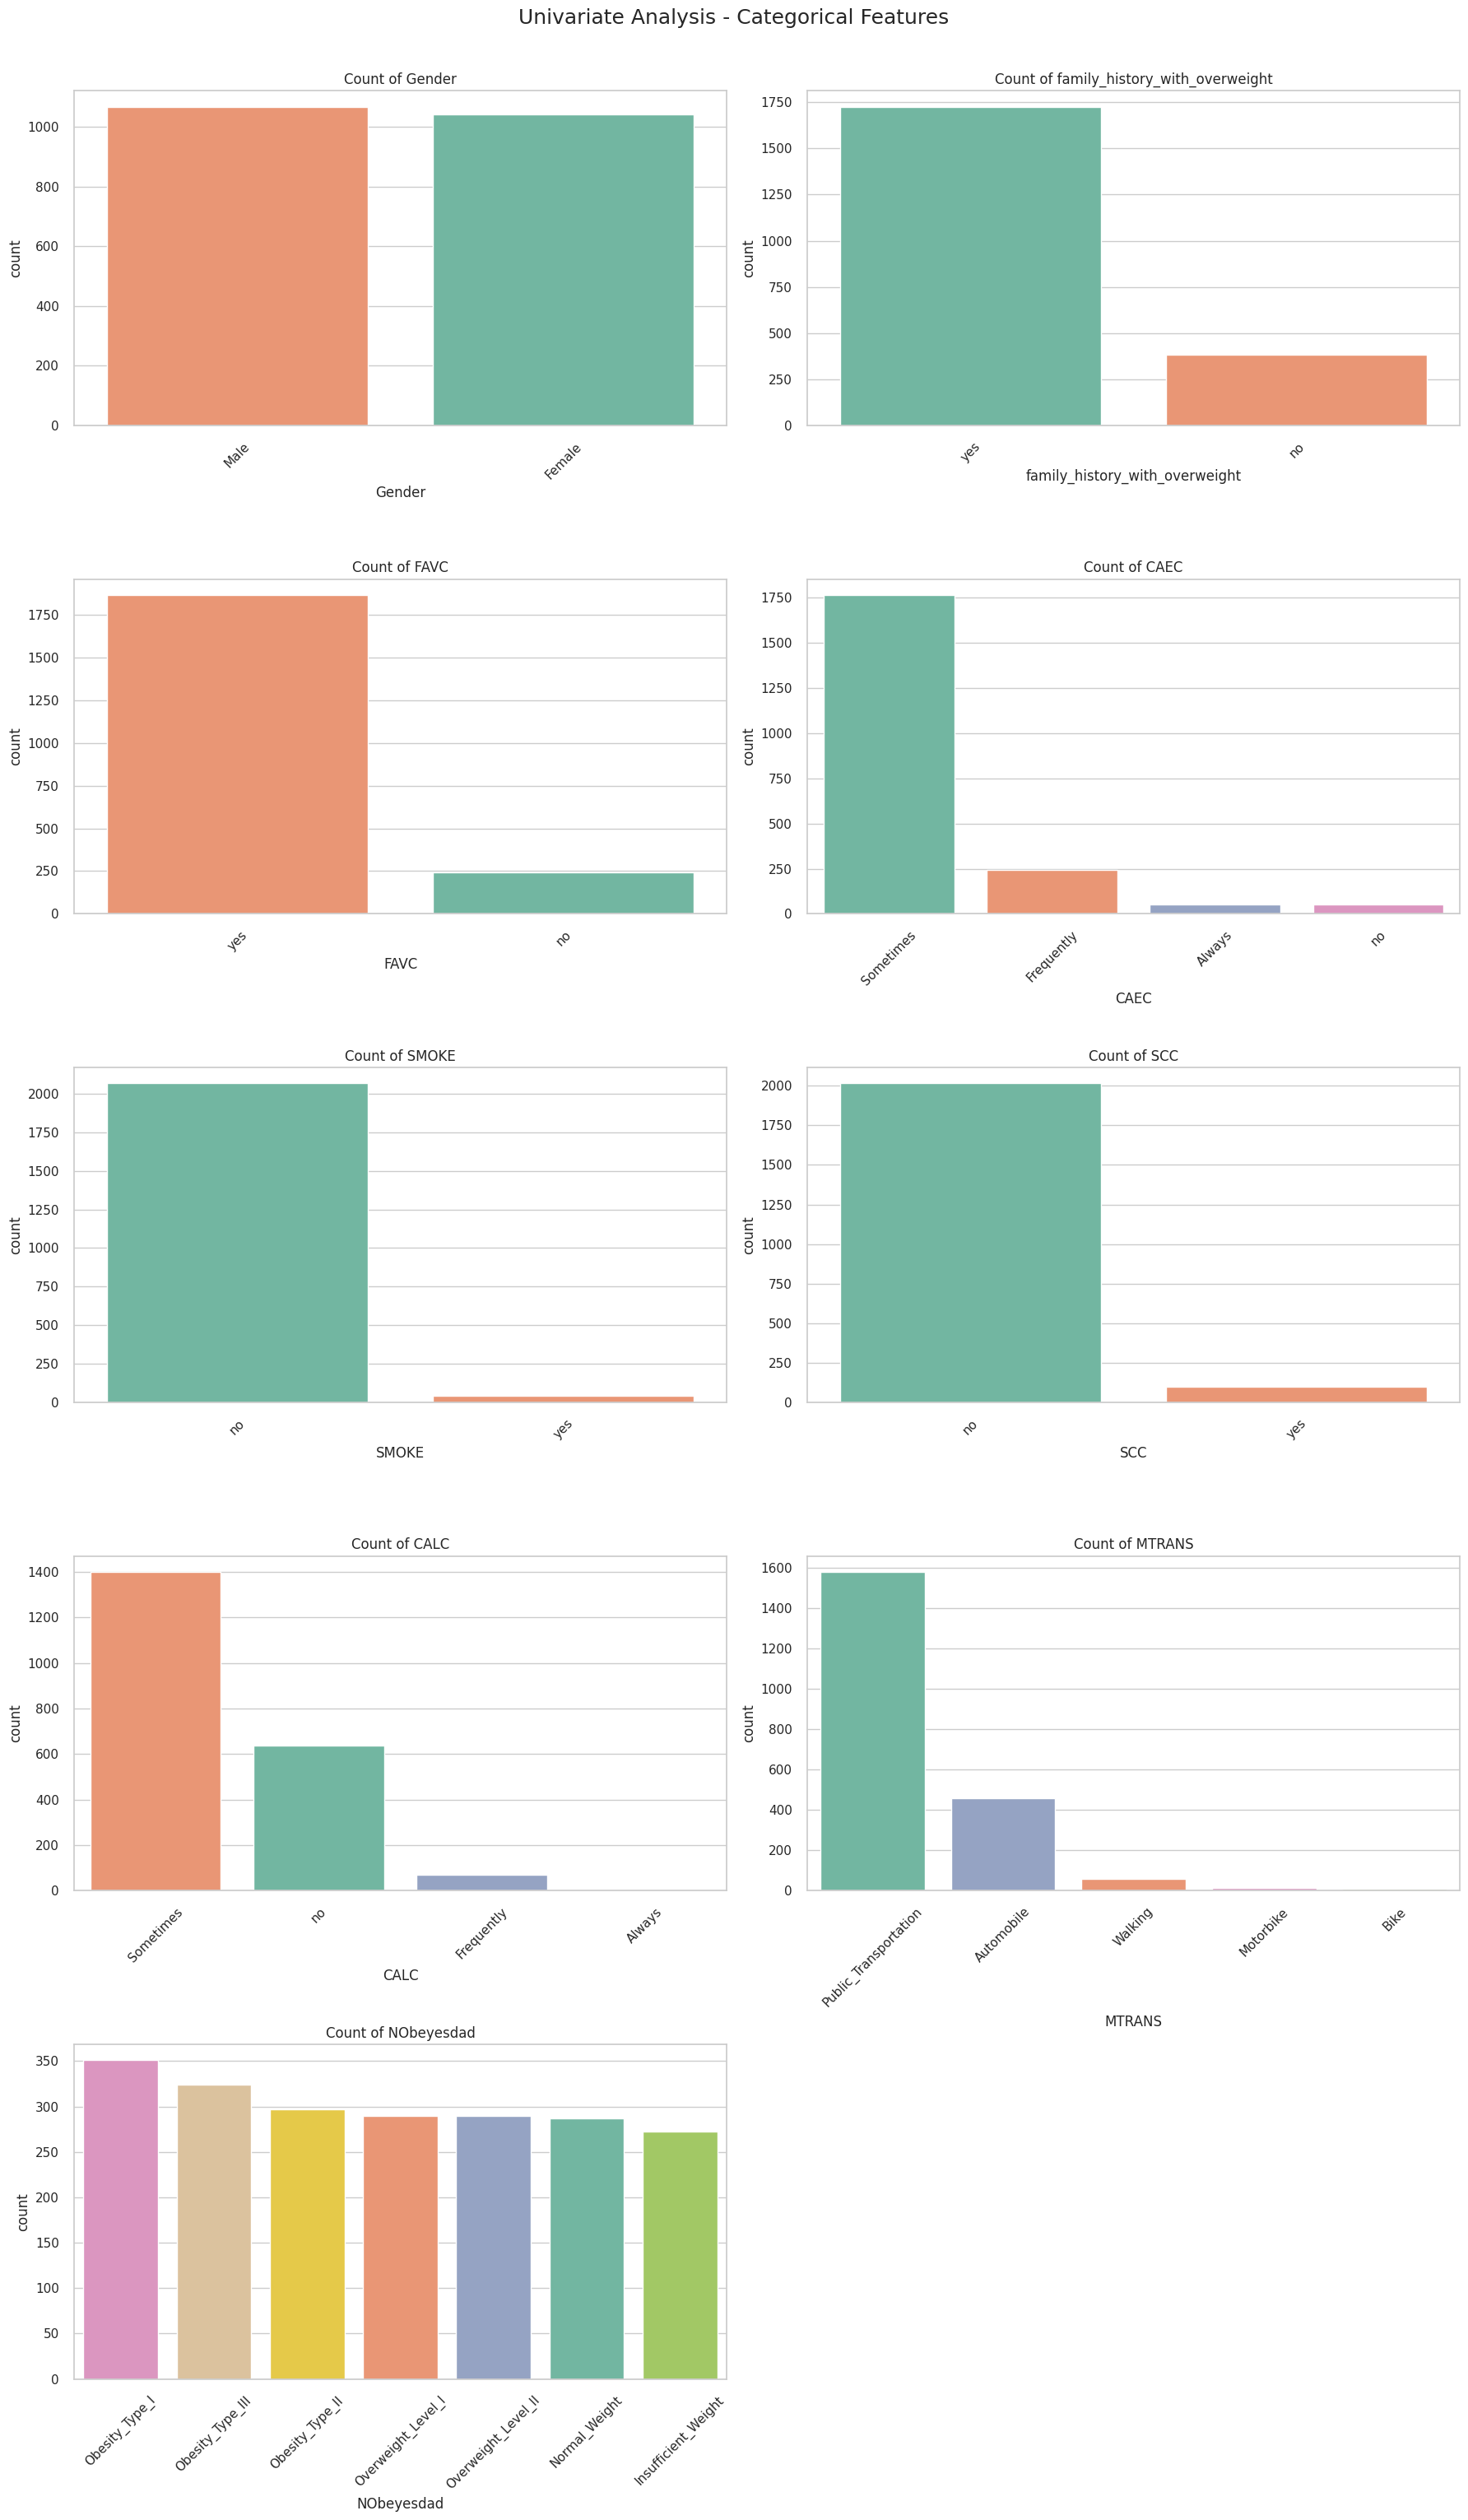

In [17]:
# Ploting distribution graph for Categorical Features

categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC','SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

plt.figure(figsize=(18, 30))
for i, col in enumerate(categorical_cols):
    plt.subplot(5, 2, i + 1)
    sns.countplot(data=raw_data,x=col,hue=col,order=raw_data[col].value_counts().index, palette="Set2",legend=False)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle("Univariate Analysis - Categorical Features", fontsize=18, y=1.02)
plt.show()

## Key Insights:

- **Gender:** The sample is nearly equal in gender balance, with almost the same number of males and females.

- **Families' History of Overweight:** Most people said they do not have a family history of overweight.

- **FAVC (very frequent consumption of high-cal foods):** Most of the results seem to reflect a yes response that very frequently high-cal foods are consumed.

- **CAEC (eating between meals):** Most of the participants said sometimes, with very few always or never for this variable.

- **SMOKE:** The vast majority of participants responded no to any smoking.

- **SCC (tracking calorie intake):** Most do not track their calories.

- **CALC (consumption of alcoholic drinks):** Most participants responded sometimes regarding their alcohol consumption, and several mentioned no alcohol consumption.

- **MTRANS:** The most common commuting method was public transportation, followed by cars.

- **NObeyesdad:** The obesity classes were relatively balanced, with slightly more participants being obese and overweight.


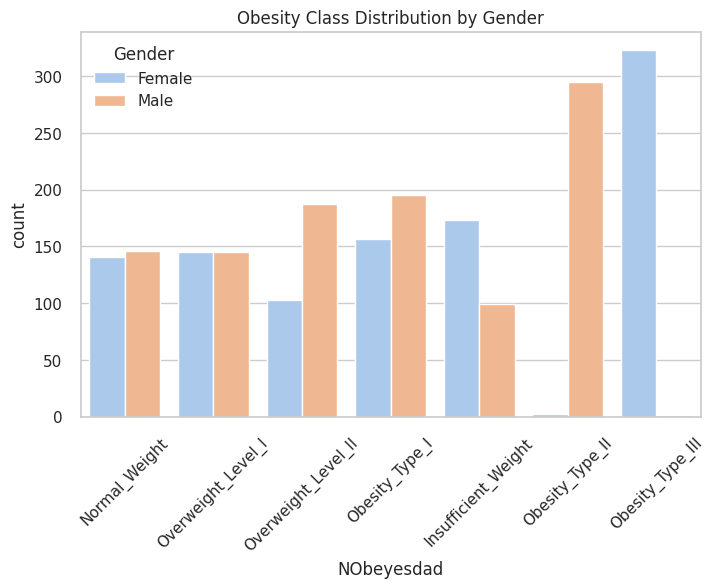

In [18]:
# Plotting distribution graph for Obesity Classes by Gender

plt.figure(figsize=(8, 5))
sns.countplot(data=raw_data, x='NObeyesdad', hue='Gender', palette='pastel')
plt.xticks(rotation=45)
plt.title('Obesity Class Distribution by Gender')
plt.show()


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Normal_Weight'),
  Text(1, 0, 'Overweight_Level_I'),
  Text(2, 0, 'Overweight_Level_II'),
  Text(3, 0, 'Obesity_Type_I'),
  Text(4, 0, 'Insufficient_Weight'),
  Text(5, 0, 'Obesity_Type_II'),
  Text(6, 0, 'Obesity_Type_III')])

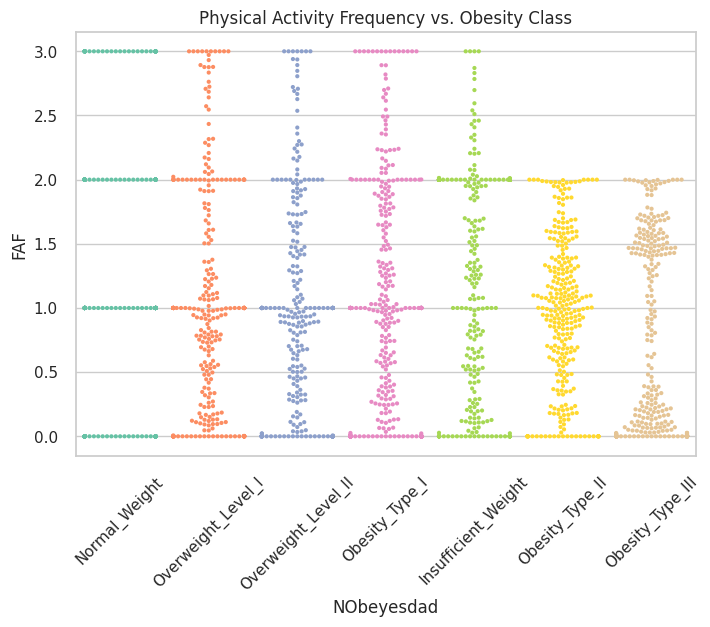

In [19]:
# Creating a swarm plot to show the relationship between physical activity and obesity classes.

sns.swarmplot(data=raw_data, x='NObeyesdad', y='FAF', palette='Set2', size=3)
plt.title('Physical Activity Frequency vs. Obesity Class')
plt.xticks(rotation=45)

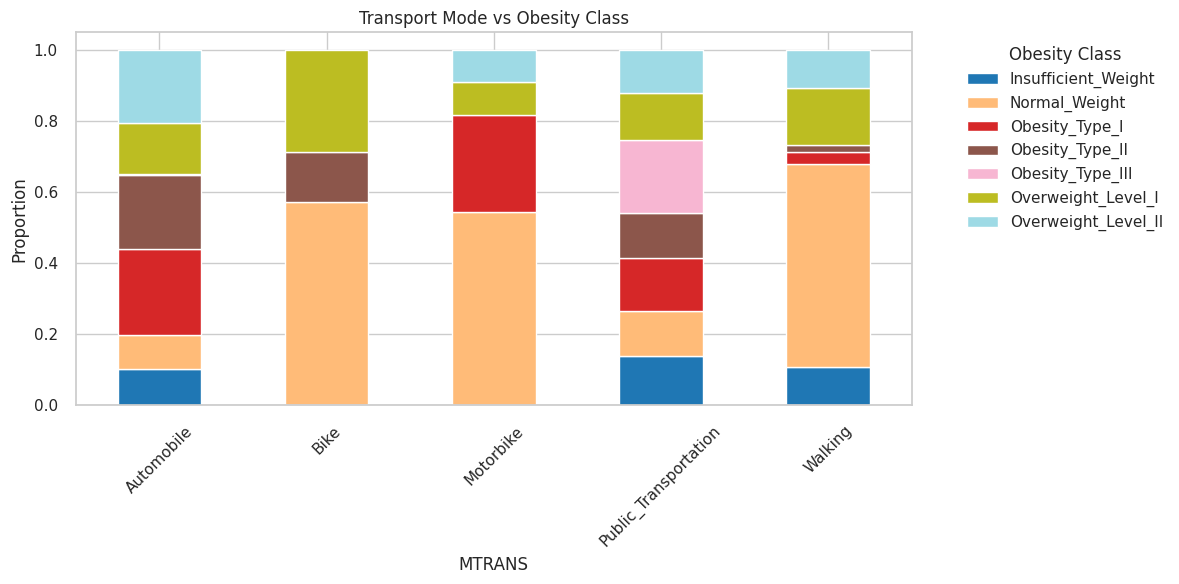

In [20]:
# Plotting a stacked bar chart to compare obesity classes across different modes of transportation

transport_obesity = pd.crosstab(raw_data['MTRANS'], raw_data['NObeyesdad'], normalize='index')

transport_obesity.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title("Transport Mode vs Obesity Class")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title='Obesity Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Key Insights:

- **Walking and Biking:**
These transportation modes had the greatest proportions of Normal Weight and Insufficient Weight individuals.
This suggests a relationship between active transportation and healthier body weight.
The walking category also has low severity obesity levels.

- **Public Transportation:**
It is a mixture of all the weight categories.
Because there are moderate overweight and obesity rates, and acceptable levels of Obesity Type III, it may be indicative of an urban sedentary lifestyle.

- **Car:**
There are higher rates of Obesity_Type_I and II and Overweight_Level_II.
These results could suggest that sedentary travel methods are associated with increased obesity levels.

- **Motorcycle:**
 The motorcycle results have similar levels of obesity and overweight.
The results show a greater incidence of Obesity_Type_I and Normal Weight in particular, showing a bimodal result with the two extremes.  

- **Bike:**
The bike category has primarily Normal Weight individuals and very low levels of obesity.
This again reinforces the idea that cycling is associated with healthier weight maintenance practices.

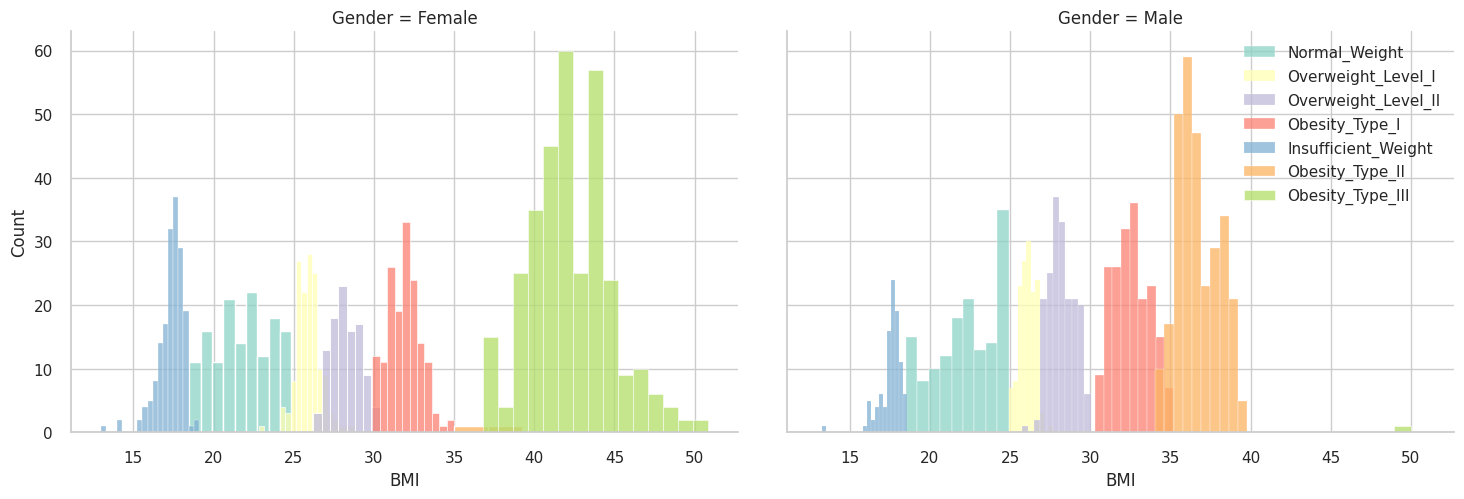

In [21]:
# Plotting gender-wise histograms for BMI distribution with respect to Obesity Classes.

temp_data = raw_data.copy()
temp_data['BMI'] = raw_data['Weight'] / (raw_data['Height'] ** 2)

byGender = sns.FacetGrid(temp_data, col="Gender", hue="NObeyesdad", palette="Set3")
byGender.map(sns.histplot, "BMI")
plt.legend(loc='upper right')
fig = plt.gcf()
fig.set_size_inches(16.5, 6.5)

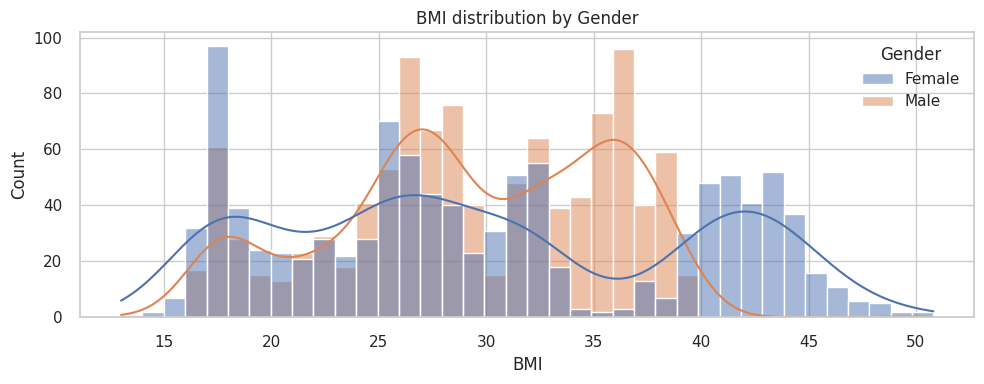

In [22]:
# Ploting the BMI distribution by gender.

plt.figure(figsize=(10, 4))
sns.histplot(data=temp_data, x="BMI", hue='Gender', binwidth=1, kde=True)
plt.title('BMI distribution by Gender')
plt.xlabel('BMI')
plt.tight_layout()
plt.show()

In [23]:
# Standardizing all features

columns = data.columns
scaler = StandardScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns=columns)
data

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,Gender_Male,CAEC_Frequently,CAEC_Sometimes,CAEC_no,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,-0.518058,-1.083871,-1.017148,0.420437,-2.801446,-0.825096,0.209831,-0.145545,-0.077032,-0.224362,-1.215955,0.511752,-1.036428,-0.332273,0.391747,-0.11095,-1.648662,1.791883,-0.065653,-0.065653,0.473464,-0.164881
1,-0.518058,-2.229181,-1.308505,0.420437,-2.801446,0.993609,0.209831,6.870728,1.574178,4.457092,2.329102,-1.199417,-1.036428,-0.332273,0.391747,-0.11095,0.606553,-0.558072,-0.065653,-0.065653,0.473464,-0.164881
2,-0.038155,0.977687,-0.543694,0.420437,-2.801446,-0.825096,0.209831,-0.145545,-0.077032,-0.224362,1.147416,0.511752,0.964852,-0.332273,0.391747,-0.11095,-1.648662,-0.558072,-0.065653,-0.065653,0.473464,-0.164881
3,0.921652,0.977687,-0.179498,-2.378475,-2.801446,0.993609,0.209831,-0.145545,-0.077032,-0.224362,1.147416,-1.199417,0.964852,-0.332273,0.391747,-0.11095,-1.648662,-0.558072,-0.065653,-0.065653,-2.112093,6.064964
4,1.401555,-1.083871,-1.417763,-2.378475,0.356958,-0.825096,0.209831,-0.145545,-0.077032,-0.224362,-1.215955,-1.199417,0.964852,-0.332273,0.391747,-0.11095,0.606553,-0.558072,-0.065653,-0.065653,-2.112093,-0.164881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,-0.523615,-0.044731,1.437841,0.420437,0.356958,0.993609,0.209831,-0.145545,-0.525931,-0.224362,0.764868,0.351324,-1.036428,-0.332273,0.391747,-0.11095,0.606553,-0.558072,-0.065653,-0.065653,0.473464,-0.164881
1394,-0.282200,0.388815,1.522859,0.420437,0.356958,0.993609,0.209831,-0.145545,-0.068561,-0.224362,0.369146,-0.173965,-1.036428,-0.332273,0.391747,-0.11095,0.606553,-0.558072,-0.065653,-0.065653,0.473464,-0.164881
1395,-0.152363,0.430298,1.520907,0.420437,0.356958,0.993609,0.209831,-0.145545,0.012452,-0.224362,0.455195,-0.093509,-1.036428,-0.332273,0.391747,-0.11095,0.606553,-0.558072,-0.065653,-0.065653,0.473464,-0.164881
1396,0.288644,0.284202,1.508426,0.420437,0.356958,0.993609,0.209831,-0.145545,1.330358,-0.224362,0.130111,-0.196612,-1.036428,-0.332273,0.391747,-0.11095,0.606553,-0.558072,-0.065653,-0.065653,0.473464,-0.164881


For all features to equally contribute to clustering and analysis, we used z-score normalisation with StandardScaler. This transforms the dataset to standardise it by centring the values of each feature to mean 0, and scaling it to a standard deviation of 1. Scaling left the column structure the same to retain consistency for further analysis.

# **Task 5 – Dimensionality Reduction**

To reduce the dimensionality of the dataset, retaining the most important information, we employed *Principal Component Analysis (PCA)*. PCA compresses the dataset into a set of components, preserving the maximum variance, allowing us to summarise the data in lower dimensions, retaining its basic structure.


## Measures Taken:
1. **PCA Transformation:** We applied PCA to the scaled data in order to get the principal components, which pick a direction of maximum variance in the data.
2. **Explained Variance Analysis:** We have calculated the explained variance ratio for all components, and it is a percentage measure of total variance explained by each component. We have also represented cumulative explained variance in such a way that we can see the amount of variance that we are leaving behind while we continue to add more components.
3. **Selection of Components:** According to the above plot of variances and our need to retain at least 95% of the total variance, we computed the number of components necessary to ensure this.

In [24]:
# Applying PCA to the standardized data to extract all principal components for variance analysis.
pca_full = PCA()
data_pca = pca_full.fit_transform(data)

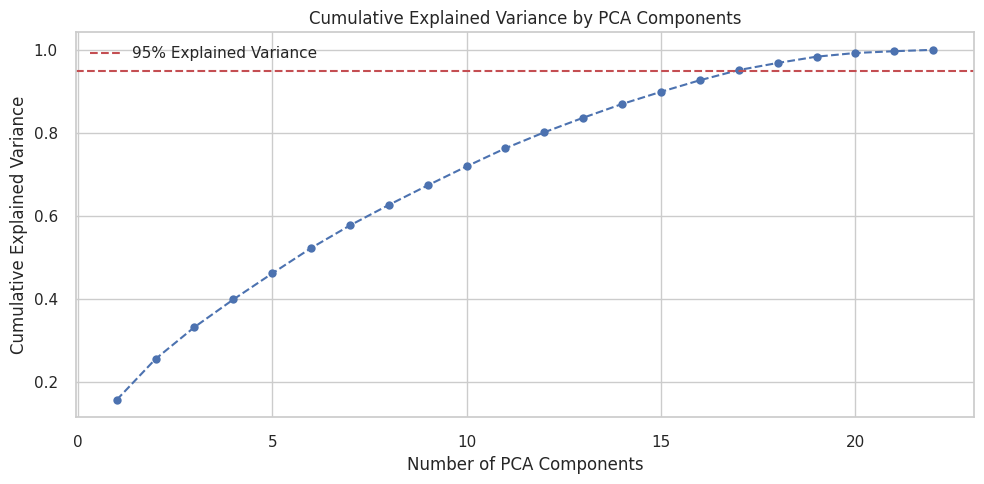

In [25]:
# Ploting the cumulative explained variance to determine how many PCA components are needed to capture at least 95% of the dataset's variance.

explained_var_ratio = pca_full.explained_variance_ratio_
cumulative_explained_var = np.cumsum(explained_var_ratio)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var_ratio) + 1), cumulative_explained_var, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# Selecting the minimum number of PCA components needed to retain ≥95% of the variance and appling dimensionality reduction accordingly.

n_components = np.argmax(cumulative_explained_var >= 0.95) + 1
print(f"\n Number of components to explain ≥95% variance: {n_components}")

pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data)


 Number of components to explain ≥95% variance: 17


## Results:
The graph shows how cumulative variance changes with the addition of PCA components. On the basis of cumulative variance, we can determine the minimum number of components required to explain 95% of the variance of our data. This will eliminate dimension at a cost of very little information.

## Observations from the Explained Variance Plot:

- Steep slope: The other components capture increasingly more variance with very rapid conditions, and the first components naturally capture the most variance in their representation.
- Number of components: The plot suggests that we would require 17 components with approximately 95% variance of our data preserved after PCA, i.e. 17-d lower-dimensional representation would be the optimal number of components to preserve the most important information.
- Diminishing Returns: After the 17th component, the curve starts to flatten, which shows that additional components would only add, and not in a significant manner, to explaining additional variance.

## Conclusion

We have 17 PCA components, which give us a good trade-off between the representation of the dataset and its dimensionality reduction, retaining most of its variance. This dimensionality reduction can aid in clustering in later steps and can also be a good representative of clusters in later steps.

# **Task 6 – Exploratory Data Analysis: Clustering**

# 6.1.1 K-Means (Preprocessed Data)

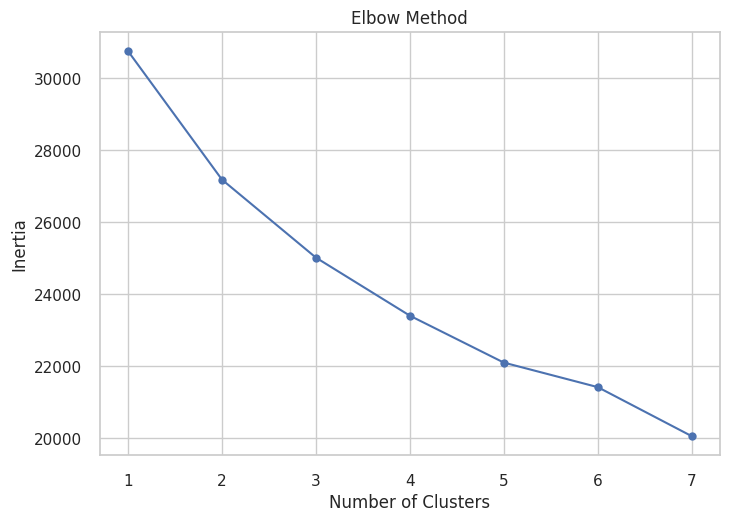

In [27]:
# Using the elbow Method to find the optimal number of clusters.

inertia = []
k_range = range(1, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k,init='k-means++',random_state=86)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow curve Method
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

The Elbow Method is used to determine the ideal cluster quantity by plotting the inertia (the within-cluster sum of squares) for various values of k. In the present plot, the inertia continues to decrease as the number of clusters increases; however, it does appear there is a slower rate of improvement after k = 4.

The most noticeable "elbow" in the plot occurs around k = 4, where the decrease in inertia slows down significantly. This suggests that adding more clusters beyond k = 4 gives diminishing improvements in cluster compactness.

Using k = 4 produces distinct groupings in the data, which provides the best trade-off between compactness and interpretability without over fitting the number of clusters. This choice of k = 4 will be used for clustering in subsequent steps, providing a well-defined clustering structure.

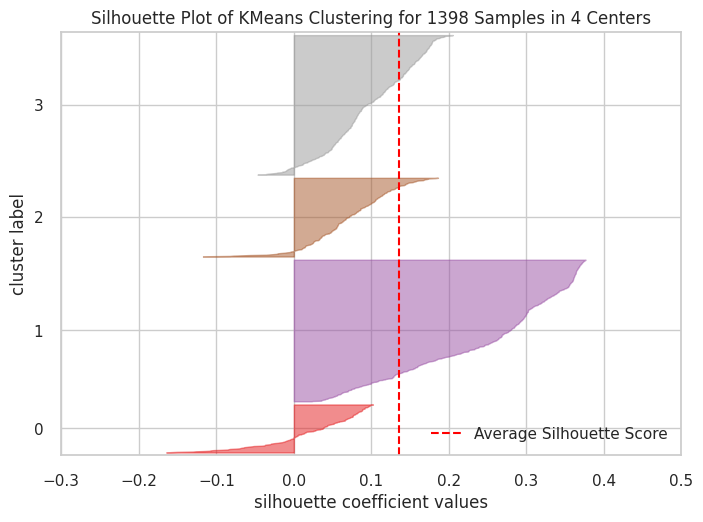

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1398 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [28]:
# Visualizing the clustering quality using a silhouette plot

model = KMeans(n_clusters=4, init='k-means++', random_state=86)

visualizer = SilhouetteVisualizer(model)
visualizer.fit(data)
visualizer.show()

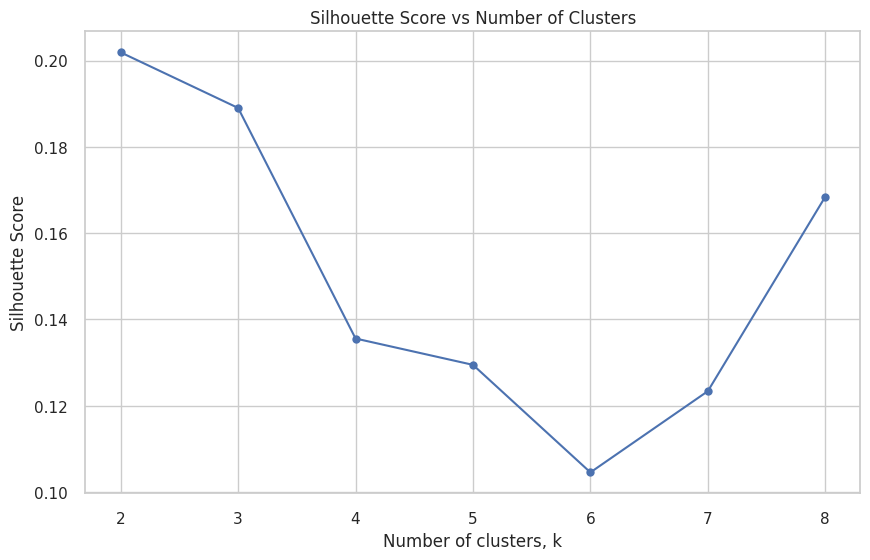

In [29]:
# Calculating the silhouette scores for different values of k to assess the clustering quality and identify the optimal number of clusters.
silhouette_scores = []
k_values = [2, 3, 4, 5, 6, 7, 8]

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=86)
    cluster_labels = kmeans.fit_predict(data)
    score = silhouette_score(data, cluster_labels)
    silhouette_scores.append(score)


# Ploting the silhouette scores for various cluster counts to visually identify the optimal number of clusters based on clustering quality.
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xticks(k_values)
plt.grid(True)
plt.show()


##  Silhouette Score for Identifying Optimal k (Clusters)

The Silhouette Score is a commonly used means of assessing the quality of clustering results. It gives a measure of how well each data point is clustered relative to other clusters. The value of the similarity score ranges from −1 to 1.
- Values around 1 suggest the data point is strongly fitted to the cluster it resides in and weakly fitted to the neighbouring clusters, which indicates a well-separated and distinct cluster structure.
- Values around 0 mean that the point is on the edge of the clusters, meaning uncertainty in cluster affiliation.
- Values less than 0 signify that the point probably should have been in another cluster and suggest that the clustering is likely not a good clustering result.

Thus, larger silhouette scores generally suggest that the clustering assessment is better, while smaller or negative silhouette scores generally imply worse or incorrect clustering.


## Methodology & Interpretation

K values were selected from an interval of 2 to 8 by applying the K-means algorithm. The silhouette score was computed for each respective k value to investigate the goodness of clustering. The scores were charted in order to see how well the data were being separated by changing the number of clusters.

The score for k = 4 is still pretty good, depicting relatively well-separated and understandable clusters and still well capable of detecting small subgroup patterns significantly.

In [30]:
# Appling KMeans clustering for preprocessed data with the specified number of clusters and predicting a cluster label.

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=86)
Kmeans_labels=kmeans.fit_predict(data)
Kmeans_labels

array([2, 1, 2, ..., 1, 1, 1], dtype=int32)

In [31]:
# Calculating the silhouette score for K-Means preprocessed data

Silhouette_score_kmeans = silhouette_score(data, Kmeans_labels)
print(f"Silhouette Score for K_Means: {Silhouette_score_kmeans}")

Silhouette Score for K_Means: 0.13555431463920406


### **Davies-Bouldin Score**

The Davies-Bouldin Score is a metric for validating clustering results. It quantifies the degree of separation and compactness of the clusters.

- The lower the Davies-Bouldin score indicates that the Clusters are dense (i.e., compact)and Clusters are separated from one another.
- The higher score demonstrates poor clustering because the clusters are overlapping or poorly defined.



In [32]:
# Calculate  the Davies-Bouldin score for K-Means preprocessed data

Davies_bouldin_score_kmeans = davies_bouldin_score(data, Kmeans_labels)
print(f"Davis Bouldin Score for K_Means: {Davies_bouldin_score_kmeans}")

Davis Bouldin Score for K_Means: 2.1838683821969203


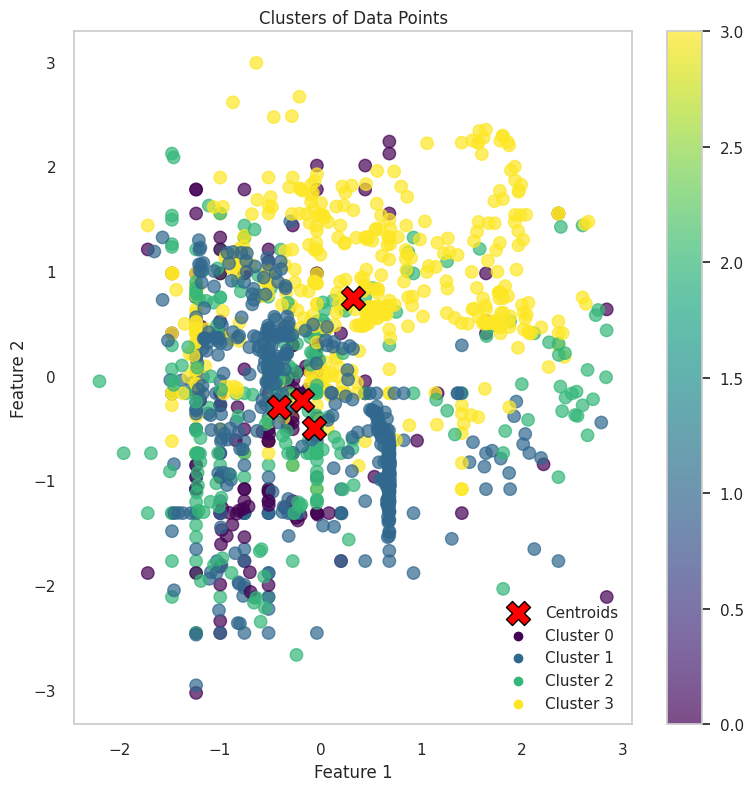

In [33]:
# Visualizing KMeans clustering in 2D plot with cluster centroids

centroids_kmeans = kmeans.cluster_centers_

plt.figure(figsize=(9, 9))

scatter = plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=Kmeans_labels, cmap='viridis', s=80, alpha=0.7)
plt.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], s=300, c='red',edgecolors='black', marker='X', label='Centroids')

for cluster_id in np.unique(Kmeans_labels):
    plt.scatter([], [], c=scatter.cmap(scatter.norm(cluster_id)), label=f'Cluster {cluster_id}')

plt.colorbar(scatter)
plt.title('Clusters of Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()

### K-Means Clustering Visualisation (k = 4)
This scatterplot is a depiction of the iteration of K-Means with k = 4.

- Each point is a sample representing a data observation, with the colour indicating the cluster assigned by the K-Means algorithm.
- The clusters are colored using the 'viridis' colourmap, with the colour bar on the right corresponding to cluster indices (0 to 3).
- The centroids of each cluster are shown with a red 'X' marker. These are the central points around which K-Means grouped the data.
- The axes labelled Feature 1 and Feature 2 represent two data dimensions, which could be either original features.
- A legend is included to differentiate the centroids, and a grid is added to enhance readability.

### Interpretation
- The separation of clusters is apparent at the level of Cluster 3 (yellow), which shows the most dissociation from the other clusters in the dataset. Clusters 0, 1, and 2 have some overlap, indicating that K-Means detected similarities in certain areas of this data. The amount of overlap may be decreased with PCA-based clustering (data_pca) because PCA not only compresses the features but also helps to decorrelate them.

- The centroids are plotted correctly in the densest areas of these clusters, indicating that the algorithm converged reasonably.

- Additionally, since the clustering was performed on the original features, there may be a greater degree of dimensional noise and overlap than if we had performed PCA clustering. In other words, some clusters may look less distinct than PCA-reduced clustering.



Overall, this plot provides an opportunity to visualise and assess cluster quality and even examine spatial distributions of data points in several groups.


In [34]:
# Identifying the cluster distribution for each data point

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=86)
clusters = kmeans.fit_predict(data)

data_Cluster = data.copy()
data_Cluster['Cluster'] = clusters

print("Cluster Distribution:")
print(data_Cluster['Cluster'].value_counts())

Cluster Distribution:
Cluster
1    485
3    478
2    270
0    165
Name: count, dtype: int64


In [35]:
data_Cluster.head()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,Gender_Male,CAEC_Frequently,CAEC_Sometimes,CAEC_no,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,Cluster
0,-0.518058,-1.083871,-1.017148,0.420437,-2.801446,-0.825096,0.209831,-0.145545,-0.077032,-0.224362,-1.215955,0.511752,-1.036428,-0.332273,0.391747,-0.11095,-1.648662,1.791883,-0.065653,-0.065653,0.473464,-0.164881,2
1,-0.518058,-2.229181,-1.308505,0.420437,-2.801446,0.993609,0.209831,6.870728,1.574178,4.457092,2.329102,-1.199417,-1.036428,-0.332273,0.391747,-0.11095,0.606553,-0.558072,-0.065653,-0.065653,0.473464,-0.164881,1
2,-0.038155,0.977687,-0.543694,0.420437,-2.801446,-0.825096,0.209831,-0.145545,-0.077032,-0.224362,1.147416,0.511752,0.964852,-0.332273,0.391747,-0.11095,-1.648662,-0.558072,-0.065653,-0.065653,0.473464,-0.164881,2
3,0.921652,0.977687,-0.179498,-2.378475,-2.801446,0.993609,0.209831,-0.145545,-0.077032,-0.224362,1.147416,-1.199417,0.964852,-0.332273,0.391747,-0.11095,-1.648662,-0.558072,-0.065653,-0.065653,-2.112093,6.064964,2
4,1.401555,-1.083871,-1.417763,-2.378475,0.356958,-0.825096,0.209831,-0.145545,-0.077032,-0.224362,-1.215955,-1.199417,0.964852,-0.332273,0.391747,-0.11095,0.606553,-0.558072,-0.065653,-0.065653,-2.112093,-0.164881,3


# 6.1.2 K-Means (PCA Data)

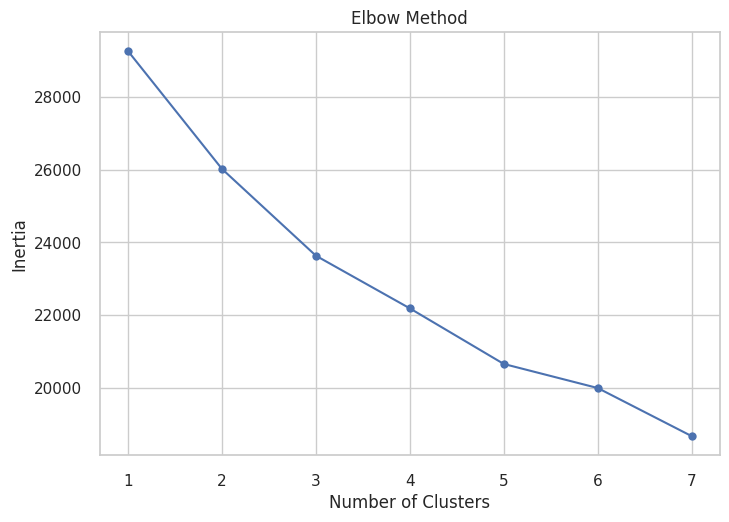

In [36]:
# Using the elbow Method to find the optimal number of clusters.

inertia = []
k_range = range(1, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k,init='k-means++',random_state=86)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow curve Method
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

The elbow point on the graph appears at k = 4, where the drop in inertia starts to slow down. This means that using 4 clusters gives a good balance between keeping the clusters tight and not making the model too complex.

So, choosing 4 clusters for the K-Means++ on the PCA-reduced data is a smart choice. It helps group the data in a way that is both meaningful and easy to understand.

In [37]:
# Appling KMeans clustering for PCA data with the specified number of clusters and predicting a cluster label.

kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=86)
Kmeans_labels_pca=kmeans_pca.fit_predict(data_pca)
Kmeans_labels_pca

array([3, 2, 3, ..., 1, 1, 1], dtype=int32)

In [38]:
# Calculating the silhouette score for K-Means PCA data

Silhouette_score_kmeans_PCA = silhouette_score(data_pca, Kmeans_labels_pca)
print(f"\nSilhouette Score (K-Means with PCA): {Silhouette_score_kmeans_PCA:.4f}")


Silhouette Score (K-Means with PCA): 0.2259


In [39]:
# Calculate  the Davies-Bouldin score for K-Means PCA data

Davies_bouldin_score_kmeans_PCA = davies_bouldin_score(data_pca, Kmeans_labels_pca)
print(f"Davis Bouldin Score (K-Means with PCA): {Davies_bouldin_score_kmeans_PCA:.4f}")

Davis Bouldin Score (K-Means with PCA): 2.2152


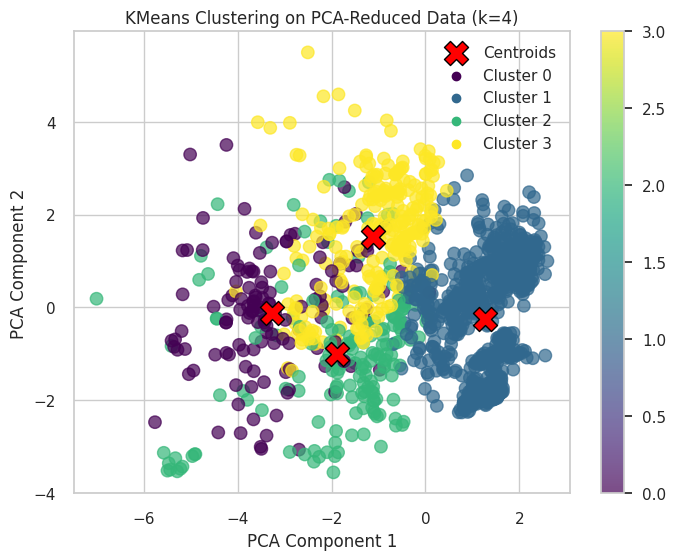

In [40]:
# Visualizing KMeans clustering for PCA data in 2D plot with cluster centroids

centroids_pca = kmeans_pca.cluster_centers_

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=Kmeans_labels_pca, cmap='viridis', s=80, alpha=0.7)

plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='red', edgecolors='black', marker='X', label='Centroids')

for cluster_id in np.unique(Kmeans_labels_pca):
    plt.scatter([], [], c=scatter.cmap(scatter.norm(cluster_id)), label=f'Cluster {cluster_id}')

plt.colorbar(scatter)
plt.title("KMeans Clustering on PCA-Reduced Data (k=4)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


### K-Means Clustering Visualization (k = 4)

The scatter plot below shows the *K-Means clustering with k = 4* of these data.

- Each dot represents an observation in the data, and the colour of the dot is the label the K-Means algorithm assigned to it. The clusters are colored according to the viridis colourmap, and on the right is a colour bar for cluster indices ranging from 0 to 3
- Cluster centroids are marked as red 'X' markers, i.e., the average indicates where K-Means grouped the data.

### Interpretation
- The most distinct differentiation of clusters is seen in Cluster 3 (yellow), which is very distinguishable from the rest. Clusters 0, 1, and 2 have overlapping areas, showing the K-Means algorithm captured similarities among their points. This overlap could be reduced by carrying out PCA-based clustering on compressing and decorrelating the feature set.

- The centroids are located in the *most dense regions* of their clusters, meaning that the K-Means algorithm has *converged well*.

# 6.2.1 DB-SCAN (Preprocessed Data)

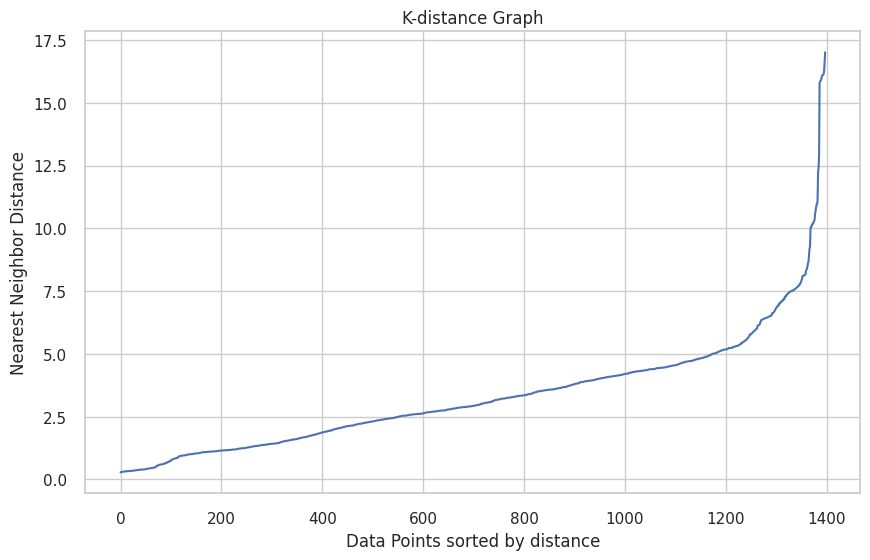

In [41]:
# Determine optimal eps using k-distance graph

neighbors = NearestNeighbors(n_neighbors=44) # Based on 22 columns in dataset (2* no of features_22=44) and drawn to identify eps value
neighbors_fit = neighbors.fit(data)
distances, indices = neighbors_fit.kneighbors(data)

# Sorting the distances for the kth nearest neighbor
distances = np.sort(distances[:, 43])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Nearest Neighbor Distance')
plt.grid(True)
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">

### K-Distance Graph for Choosing Optimal `eps` (DBSCAN)

The K-distance graph is an important technique to find the optimal eps parameter for the DBSCAN clustering algorithm. The eps parameter defines the maximum distance two samples must be from each other for one to be considered in the neighborhood of the other. An important first step for DBSCAN is to find an appropriate eps value that allows DBSCAN to appropriately differentiate cluster regions (dense) from noise regions (sparse).


### To find a good eps value:
1. The number of neighbors was set to 44 neighbors by the 2 × number of features rule of thumb (22), which is consistent with the dimensionality of the dataset.
2. For each data point, the distance to the 44th nearest neighbor was computed using the NearestNeighbors algorithm.
3. The distances were sorted in increasing order and plotted to visualize where the dense cluster areas became sparse noise areas.


The ideal eps=5.6 value would be selected just before the point the values begin to rise sharply to allow DBSCAN to create compact and well-segregated clusters while avoiding the misclassification of noise points.


### Conclusion:

The K-distance graph is a useful and visual way to decide on a meaningful eps value in the DBSCAN algorithm. By selecting an eps value at the elbow, users can choose a value for eps that well-defines clusters while ensuring an appropriate amount of noise is evenly dispersed. The K-distance graphic allows users to utilize the advantages of the strength of DBSCAN using the selected eps value of identifying clusters of arbitrary shapes and being robust to outliers.

</div>


In [42]:
# Appling DB SCAN clustering for preprocessed data with the specified number of clusters and predicting a cluster label.

dbscan = DBSCAN(eps=5.6, min_samples=44)
db_labels_raw = dbscan.fit_predict(data)
db_labels_raw

array([ 0, -1,  0, ...,  0,  0,  0])

In [43]:
# Evaluating DBSCAN clustering and identifying noise points, and calculating the silhouette score both with and without noise

data_Cluster_db = data.copy()
data_Cluster_db['Cluster'] = db_labels_raw

print("Unique cluster labels (including noise):", set(db_labels_raw))
print("Number of noise points:", sum(db_labels_raw == -1))

core_mask = db_labels_raw != -1
unique_labels = set(db_labels_raw[core_mask])

if len(unique_labels) >= 2:
    silhouette_avg = silhouette_score(data[core_mask], db_labels_raw[core_mask])
    print(f"\nSilhouette Score (DBSCAN, excluding noise): {silhouette_avg:.4f}")
else:
    print("\nSilhouette Score not meaningful: fewer than 2 clusters after removing noise.")

silhouette_score_db = silhouette_score(data, db_labels_raw)
print(f"\nApproximate Silhouette Score (including noise): {silhouette_score_db:.4f}")

Unique cluster labels (including noise): {np.int64(0), np.int64(-1)}
Number of noise points: 100

Silhouette Score not meaningful: fewer than 2 clusters after removing noise.

Approximate Silhouette Score (including noise): 0.4432


## Explanation
- This code evaluates the performance of DBSCAN clustering by first displaying the unique cluster labels assigned to each data point, including the label -1, which denotes noise.
- It then counts how many points have been identified as noise. To ensure a meaningful evaluation, the silhouette score is first calculated by excluding noise points—this is only done if at least two valid clusters remain after removing the noise.
- This filtered silhouette score gives a more accurate measure of how well DBSCAN has grouped similar data points. However, if there are not enough clusters to compute a valid score after filtering, the code instead calculates an approximate silhouette score using the entire dataset, including noise.
-Although this fallback score is less precise, it still offers a general indication of clustering performance when a clean, noise-free evaluation isn't feasible.


In [44]:
# Calculate  the Davies-Bouldin score for DB SCAN Preprocessed data

Davies_bouldin_score_db = davies_bouldin_score(data, db_labels_raw)
print(f"Davies-Bouldin score : {Davies_bouldin_score_db:.4f}")

Davies-Bouldin score : 2.9001


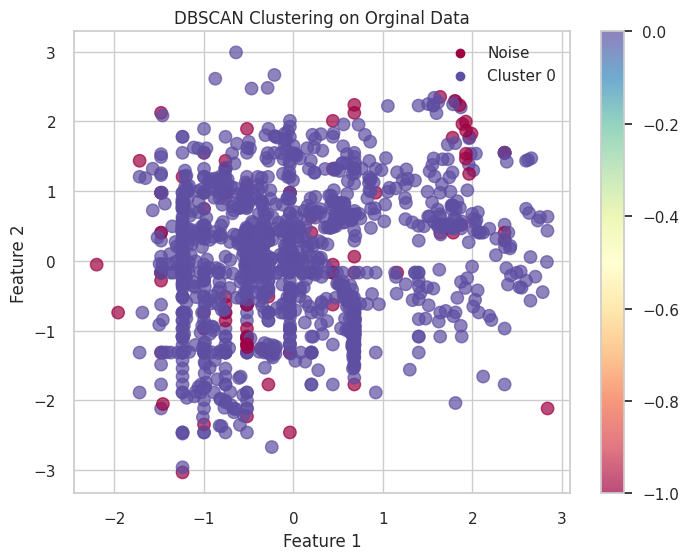

In [45]:
# Visualizing DB SCAN clustering for preprocessed dat in 2D plot with cluster centroids

unique_labels = np.unique(db_labels_raw)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data.iloc[:, 0], data.iloc[:, 1],c=db_labels_raw, cmap='Spectral', s=80, alpha=0.7)

for cluster_id in unique_labels:
    color = scatter.cmap(scatter.norm(cluster_id))
    label = f"Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    plt.scatter([], [], c=color, label=label)

plt.colorbar(scatter)
plt.title("DBSCAN Clustering on Orginal Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

### Plot Purpose:
- It is a plot which is obtained via **DBSCAN clustering** of the original data.
- It graphically distinguishes **clustered data points** and **noise/outliers**.

### Observations:
- The plot illustrates **densely aggregated clusters** in the interior and **sparse points** along the boundaries.
- DBSCAN has identified **dense clusters correctly**, and **noise points are well isolated**.
- The clustering result indicates **areas of high density** and areas **too sparse to be clustered**.
- Points labeled as **-1** by DBSCAN are treated as **noise** and colored differently (tending to be on the edge of the colorbar).

### Conclusion:
- The above visualization confirms **DBSCAN's ability** to identify **dense clusters and noise points**.
- It provides a good indication of how well the algorithm has captured the **structure of the data** in its original feature space.


# 6.2.2 DB-SCAN (PCA Data)

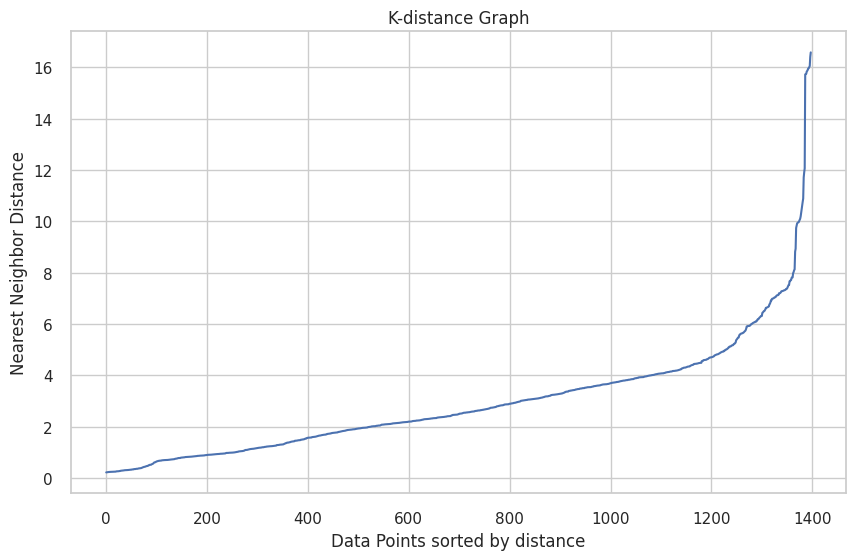

In [46]:
# Determine optimal eps using k-distance graph

neighbors = NearestNeighbors(n_neighbors=34)
neighbors_fit = neighbors.fit(data_pca)
distances, indices = neighbors_fit.kneighbors(data_pca)

# Sort the distances for the kth nearest neighbor
distances = np.sort(distances[:, 33])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Nearest Neighbor Distance')
plt.grid(True)
plt.legend()
plt.show()


### K-Distance Graph for Optimal `eps` (DBSCAN on PCA Data)

This graph is utilised to find the optimal value of `eps` for DBSCAN after PCA transformation has been applied. The `eps` specifies the radius of the clustering neighbourhood.


### Method:
- Used **34 neighbours** (2 × 17 PCA features).
- Calculated the distances of each point to its 34th nearest neighbour.
- Sorted and plotted these distances to see where the elbow is.

### Observations:
- the curve gradually increases then sharply increases.
- The elbow is the dividing line between cluster points and outliers noise.
- The best eps=5.6 is right before the noticeable increase in distances.

### Conclusions:
By selecting the eps at the elbow we ensured the clusters would be dense and well separated with little noise producing the best performance from from DBSCAN on PCA reduced data.

In [47]:
# Appling DB SCAN clustering for PCA data with the specified number of clusters and predicting a cluster label.

dbscan_pca = DBSCAN(eps=5.6, min_samples=34)
db_labels_pca = dbscan_pca.fit_predict(data_pca)
db_labels_pca

array([ 0, -1,  0, ...,  0,  0,  0])

In [48]:
data_pca_df = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])

In [49]:
# Evaluating DBSCAN clustering for PCA data and identifying noise points, and calculating the silhouette score both with and without noise

data_Cluster_db_pca = data_pca_df.copy()
data_Cluster_db_pca['Cluster'] = db_labels_pca

print("Unique cluster labels (including noise):", set(db_labels_pca))
print("Number of noise points:", sum(db_labels_pca == -1))

core_mask = db_labels_pca != -1
unique_labels = set(db_labels_pca[core_mask])

if len(unique_labels) >= 2:
    silhouette_avg = silhouette_score(data_pca[core_mask], db_labels_pca[core_mask])
    print(f"\nSilhouette Score (DBSCAN, excluding noise): {silhouette_avg:.4f}")
else:
    print("\nSilhouette Score not meaningful: fewer than 2 clusters after removing noise.")

Silhouette_score_db_PCA = silhouette_score(data_pca, db_labels_pca)
print(f"\nApproximate Silhouette Score for PCA data(including noise): {Silhouette_score_db_PCA:.4f}")

Unique cluster labels (including noise): {np.int64(0), np.int64(-1)}
Number of noise points: 93

Silhouette Score not meaningful: fewer than 2 clusters after removing noise.

Approximate Silhouette Score for PCA data(including noise): 0.4615


## Explaination
- The code prints the unique cluster labels, where `-1` indicates noise, and displays the number of points labeled as noise by DBSCAN.

- To compute an accurate **Silhouette Score**, the code removes all noise points. It checks whether **at least two valid clusters** remain (excluding noise). If this condition is met, the silhouette score is calculated only on the core clusters to better reflect clustering quality.

- In this case, only one valid cluster was detected after noise removal, so the silhouette score is **not meaningful**. This suggests that DBSCAN was unable to form more than one cluster when applied to the **PCA-reduced data**.

- Nevertheless, an **approximate silhouette score** (0.4615) is computed using **all data points including noise**. While this score is less accurate due to the presence of outliers, it serves as a fallback metric to get a rough idea of the clustering performance when valid clusters are too few.


In [50]:
# Calculate  the Davies-Bouldin score for DB SCAN PCA data

Davies_bouldin_score_db_PCA = davies_bouldin_score(data_pca, db_labels_pca)
print(f"Davies-Bouldin score for PCA data: {Davies_bouldin_score_db_PCA:.4f}")

Davies-Bouldin score for PCA data: 2.7636


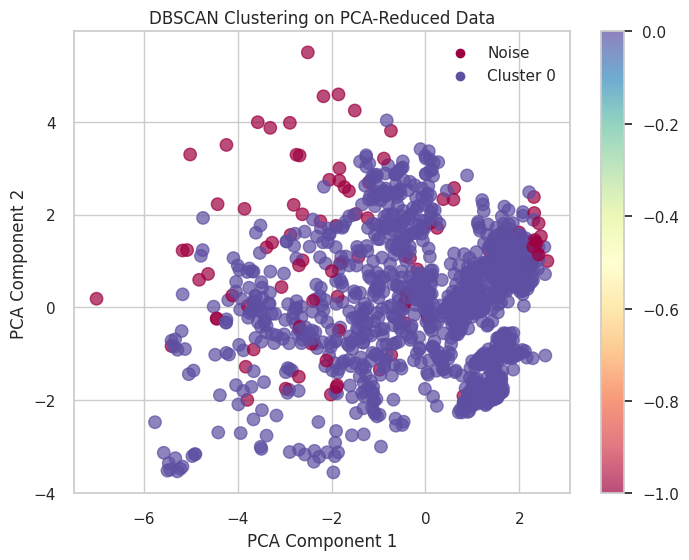

In [51]:
# Visualizing DB SCAN clustering for preprocessed dat in 2D plot with cluster centroids

unique_labels = np.unique(db_labels_pca)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=db_labels_pca, cmap='Spectral', s=80, alpha=0.7)

for cluster_id in unique_labels:
    color = scatter.cmap(scatter.norm(cluster_id))
    label = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    plt.scatter([], [], c=color, label=label)

plt.colorbar(scatter)
plt.title("DBSCAN Clustering on PCA-Reduced Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

## Observations:
- Clusters appear denser and more clearly separated from plots of the original dataset

- Outliers or noisy points (label -1) are seen, spread around the boundary of the clusters.

- Compared to clustering on the original data, the overlap between clusters is reduced, improving the readability.

# 6.3.1 Hierarchical agglomerative clustering - HAC (Preprocessed Data)

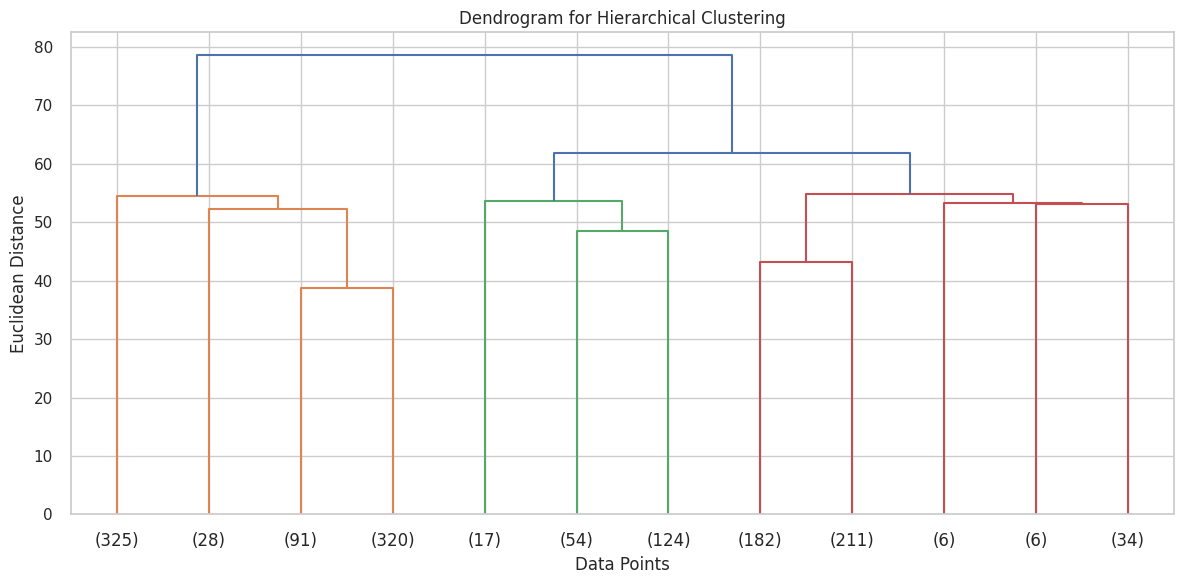

In [52]:
# Plotting the dendrogram to visualize the clustering structure

linked = linkage(data, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=12) #few features are truncated to get perfect plot

plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.tight_layout()
plt.show()

### Axes and Visual Features
On the x-axis, the individual data points are aligned, while on the y-axis, the distance between clusters at merger is measured. These colour-coded branches categorise separate cluster groups, with longer horizontal lines illustrating more distinguished separations.

### Interpretation
Sharp vertical jumps exhibit major cluster formations on the dendrogram. Two major mergers take place at distances of 60 and 70, respectively, marking where big clusters join in this plot. A horizontal cut at a distance of 60 then bestows a natural clustering of perhaps 3 or 4 clusters, depending on the analytical needs.

### Conclusion
The dendrogram actually presents a very informative hierarchy of data regarding the best possible cluster grouping. Also, it gives an understanding of how the clusters actually get formed. Thus, it supports the decision from a flexible and data-driven standpoint rather than requiring one to decide the number of clusters beforehand.


In [53]:
# Appling HAC clustering for Preprocessed data with the specified number of clusters and predicting a cluster label.

hac = AgglomerativeClustering(n_clusters=3, linkage='ward')
hac_labels = hac.fit_predict(data)
hac_labels

array([0, 1, 0, ..., 1, 1, 1])

In [54]:
# Calculating the silhouette score for HAC clustering Preprocessed data

Silhouette_score_hac = silhouette_score(data, hac_labels)
print(f"Silhouette Score for HAC: {Silhouette_score_hac:.4f}")

Silhouette Score for HAC: 0.1566


In [55]:
# Calculate  the Davies-Bouldin score for HAC clustering Preprocessed data

Davies_bouldin_score_hac= davies_bouldin_score(data, hac_labels)
print(f"Davies-Bouldin score for HAC: {Davies_bouldin_score_hac:.4f}")

Davies-Bouldin score for HAC: 2.6976


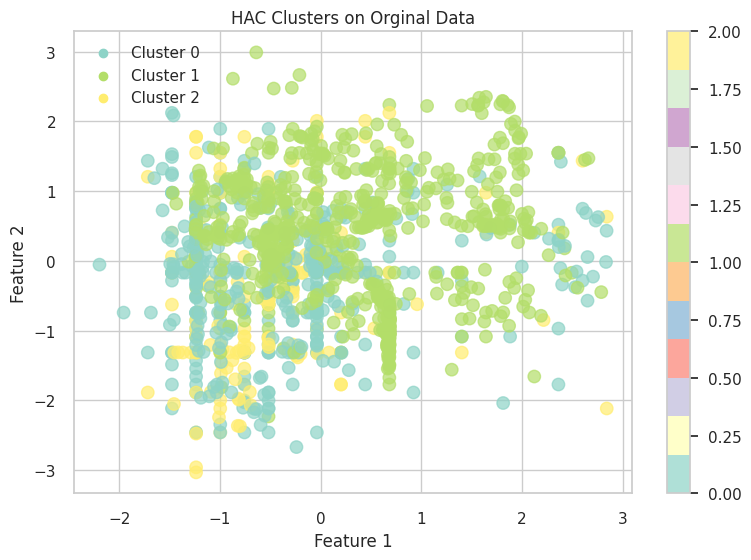

In [56]:
# Visualizing HAC clustering on preprocessed data with cluster labels

plt.figure(figsize=(9,6))

scatter = plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=hac_labels, cmap='Set3', s=80, alpha=0.7)

# Add invisible points for legend labels
for cluster_id in np.unique(hac_labels):
    plt.scatter([], [], c=scatter.cmap(scatter.norm(cluster_id)), label=f'Cluster {cluster_id}')

plt.colorbar(scatter)
plt.title("HAC Clusters on Orginal Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

The preceding scatter plot of the original data reflects the outcome of the Hierarchical Agglomerative Clustering (HAC) with 3 clusters. Each cluster is colored differently.

In terms of clustering, the groups show moderate separation . Cluster 1 seems to span a larger area than the other clusters suggesting a greater degree of diversity in the data covered. Whereas, Cluster 0 and Cluster 2 appear more compact implying denser groupings than Cluster 1.

There is also some overlap between the clusters.  As previously noted this is expected given untransformed features. Overall, the plot conveys how HAC clusters similar data points according to linkage distance even without a reduction of the dimensions.

In [57]:
# Identifying the number of cluster
cluster_counts = pd.Series(hac_labels).value_counts().sort_index()
print("Number of points in each cluster:")
print(cluster_counts)

Number of points in each cluster:
0    439
1    764
2    195
Name: count, dtype: int64


# 6.3.2 Hierarchical agglomerative clustering - HAC (PCA Data)

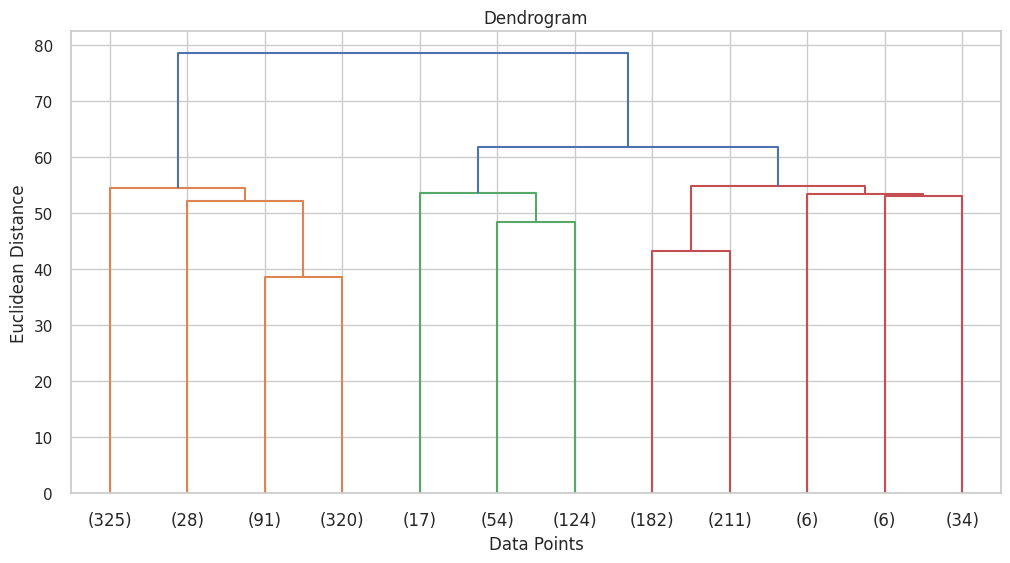

In [58]:
# Plotting the dendrogram to visualize the clustering structure of PCA Data

plt.figure(figsize=(12, 6))

linked_pca = linkage(data_pca, method='ward')
dendrogram(linked, truncate_mode='lastp', p=12) #few features are truncated to get perfect plot


plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.grid(True)
plt.show()

This dendrogram shows how hierarchical clustering groups data points  based on their Euclidean distances. Each vertical line indicates a clustering merge between clusters, while the height indicates the amount of dissimilarity for the merge.

In this dendrogram, I see a lot of large vertical jumps, particularly over the distance of 60 to 70. Therefore, these large vertical distances show where clusters are combined and are significant visual indicators for selecting the ideal number of clusters. A horizontal cut at this length indicates a natural separation in the data in three distinct clusters, which seems an appropriate and interpretable number of clusters.

Thus, we will move forward with 3 clusters as this affords an obvious simplified grouping structure from the dendrogram.

In [59]:
# Appling HAC clustering for PCA data with the specified number of clusters and predicting a cluster label.

hac_pca = AgglomerativeClustering(n_clusters=3, linkage='ward')
hac_labels_pca = hac_pca.fit_predict(data_pca)
hac_labels_pca

array([1, 0, 1, ..., 0, 0, 0])

In [60]:
# predicting the silhouette_score
Silhouette_score_hac_pca = silhouette_score(data_pca, hac_labels_pca)
print(f"Silhouette Score for HAC (with PCA): {Silhouette_score_hac_pca:.4f}")

Silhouette Score for HAC (with PCA): 0.1730


In [61]:
# Calculate  the Davies-Bouldin score for HAC clustering PCA data

Davies_bouldin_score_hac_PCA = davies_bouldin_score(data_pca, hac_labels_pca)
print(f"Davies-Bouldin score for PCA data: {Davies_bouldin_score_hac_PCA:.4f}")

Davies-Bouldin score for PCA data: 2.5989


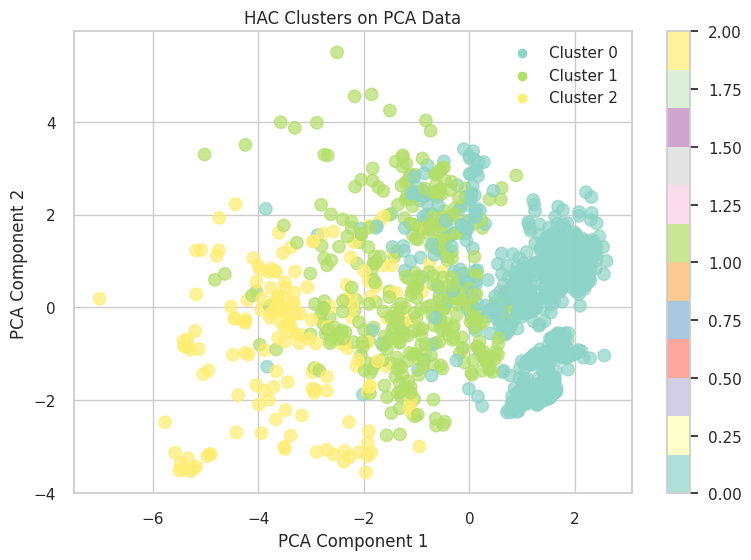

In [62]:
# Visualizing HAC clustering on PCA-reduced data with cluster labels

plt.figure(figsize=(9,6))
scatter= plt.scatter (data_pca[:, 0], data_pca[:, 1], c=hac_labels_pca,  cmap='Set3', s=80, alpha=0.7)

# Add invisible points for legend labels
for cluster_id in np.unique(hac_labels):
    plt.scatter([], [], c=scatter.cmap(scatter.norm(cluster_id)), label=f'Cluster {cluster_id}')

plt.colorbar(scatter)
plt.title("HAC Clusters on PCA Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

This scatter plot shows how the data was grouped into three clusters by applying Hierarchical Agglomerative Clustering (HAC) to the original dataset, as shown on the dendrogram.

The individual points or individual data instances in the plots are color coded for clarity as to what clusters the individual data instances belong to; these are noted as Cluster 0, Cluster 1, or Cluster 2 in the legend. The color coding indicated visually to help indicate areas of similarity and density in the data.

The clusters are somewhat evenly distributed with clear clustering and sporadic overlap in Cluster 1. Overlap is common in real world dataset. Overall the HAC algorithm has clustered the data into meaningful clusters from the previous feature structure.

In [63]:
cluster_counts = pd.Series(hac_labels_pca).value_counts().sort_index()
print("Number of points in each cluster:")
print(cluster_counts)


Number of points in each cluster:
0    826
1    393
2    179
Name: count, dtype: int64
